# Описание проекта: Промышленность

Чтобы оптимизировать производственные расходы,\
 металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали.\
Для этого комбинату нужно контролировать температуру сплава. \
Ваша задача — построить модель, которая будет её предсказывать. \
Заказчик хочет использовать разработанную модель для имитации технологического процесса. \
Изучите его, прежде чем генерировать новые признаки.


## Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн.\
Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.\
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.\
Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей.\
Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру.\
Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. \
Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.


Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. \
Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных


Данные хранятся в `Sqlite` — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

### Таблица `steel.data_arc`

- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

### Таблица `steel.data_bulk`

- `key` — номер партии;
- `Bulk1` … `Bulk15` — объём подаваемого материала.

### Таблица `steel.data_bulk_time`

- `key` — номер партии;
- `Bulk1` … `Bulk15` — время подачи материала.

#### Таблица `steel.data_gas`

- `key` — номер партии;
- `gas` — объём подаваемого газа.

#### Таблица `steel.data_temp`

- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

#### Таблица `steel.data_wire`

- `key` — номер партии;
- `Wire1` … `Wire9` — объём подаваемых проволочных материалов.

#### Таблица `steel.data_wire_time`

- `key` — номер партии;
- `Wire1` … `Wire9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## План проекта: Прогнозирование температуры стали

### **Шаг 1. Загрузка данных**

1. Подключение к базе данных в SQLite.
2. Загрузка данных из базы данных.
3. Установка константы RANDOM_STATE. Значение равно дате начала проекта (например, RANDOM_STATE = 10922 для 1 сентября 2022 года).

### **Шаг 2. Исследовательский анализ и предобработка данных**

Общие задачи:
1. Проверка всех таблиц на наличие данных и соответствие количеству таблиц условию задачи.

**Анализ таблицы steel.data_arc:**

1. Проведение исследовательского анализа данных (EDA):
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Обработка аномалий:
    - Удаление партий с аномальными значениями или замена аномальных значений.
3. Генерация новых признаков:
    - Длительность нагрева.
    - Общая мощность.
    - Соотношение активной мощности к реактивной.
    - Количество запусков нагрева электродами.
4. Агрегация наблюдений по ключу после генерации новых признаков.

**Анализ таблицы steel.data_bulk:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Обработка пропусков:
    - Пропуск означает, что материал не добавляли в партию.

**Анализ таблицы steel.data_bulk_time:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Проверка данных на адекватность (например, что подача материала не измеряется сутками).

**Анализ таблицы steel.data_gas:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.

**Анализ таблицы steel.data_temp:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Целевой признак:
    - Последняя температура партии.
3. Использование начальной температуры партии как входного признака.
4. Исключение промежуточных значений температуры для предотвращения утечки целевого признака.
5. Агрегация наблюдений:
    - Учитываются только ключи с как минимум двумя наблюдениями: первый и последний замеры температуры.
6. Обработка аномальных значений:
    - Температуры ниже 1500 градусов считаются аномальными.

**Анализ таблицы steel.data_wire:**
1. Обработка пропусков:
    - Пропуск означает, что материал не добавляли в партию.

**Анализ таблицы steel.data_wire_time:**
1. Проведение EDA:
    - Проверка наличия пропусков и аномалий.
    - Изучение распределения признаков.
2. Проверка данных на адекватность (например, что подача материала не измеряется сутками).

**Объединение таблиц по ключу:**
1. Каждой партии должно соответствовать одно наблюдение.
2. Учет всех материалов (сыпучие, проволочные) и процессов (продувка газом, нагревание).
3. Обработка возможной асинхронности времени между датчиками.

**Общий анализ объединенной таблицы:**
1. Проведение EDA объединенной таблицы.
2. Визуализация распределения каждого признака.
3. Корреляционный анализ.

**Подготовка данных для обучения:**
1. Выбор признаков для обучения.
2. Разделение данных на тренировочную и тестовую выборки (`test_size = 0.25`).
3. Подготовка данных для обучения с учетом особенностей выбранных моделей.

### **Шаг 3. Обучение модели**

1. **Рассмотрение классов моделей:**
    - Решающее дерево или случайный лес.
    - Бустинги.
    - Нейронные сети.
2. Обучение моделей и оценка их качества с использованием метрики MAE.
3. Выбор лучшей модели на основе значений метрики на кросс-валидации.
4. Подбор значений гиперпараметров:
    - Использование методов автоматизированного подбора гиперпараметров (`GridSearchCV`, `RandomizedSearchCV`, `OptunaSearchCV`, `Optuna` и другие)



### Шаг 4. Тестирование модели и демонстрация работы

1. Проверка качества лучшей модели на тестовой выборке.
2. Значение метрики MAE должно быть менее 6.8.
3. Дополнительная оценка модели с использованием R².
4. Сравнение результатов лучшей модели и константной модели.
5. Анализ важности основных признаков.
6. Проведение дополнительного исследования для одного из важных признаков:
    - Построение графика зависимости входного и целевого признаков.


### Шаг 5. Общий вывод

1. Написание общих выводов по проекту.
2. Предложение способов для дальнейшего улучшения модели.
3. Формулирование бизнес-рекомендаций заказчику.

## Подготовка данных

### Загрузка библиотек

In [1]:
# pip install phik catboost lightgbm shap

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik
# TensorFlow и Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Scikit-learn для моделей, кросс-валидации и метрик
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score

# Модели машинного обучения
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# PyTorch для создания нейросетей
import torch
import torch.nn as nn
import torch.optim as optim

# Работа с базами данных (SQLAlchemy)
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime, text, select, MetaData, Table
from sqlalchemy.orm import DeclarativeBase, Session
from sqlalchemy.schema import DropTable
from sqlalchemy.ext.compiler import compiles

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
%who

BatchNormalization	 CatBoostRegressor	 Column	 DateTime	 DeclarativeBase	 Dense	 DropTable	 Dropout	 Float	 
GridSearchCV	 Integer	 LGBMRegressor	 LinearRegression	 MetaData	 RandomForestRegressor	 RandomizedSearchCV	 Sequential	 Session	 
StandardScaler	 String	 Table	 compiles	 create_engine	 cross_val_score	 make_scorer	 mean_absolute_error	 nn	 
np	 optim	 os	 pd	 phik	 plt	 r2_score	 select	 shap	 
sns	 text	 tf	 torch	 train_test_split	 warnings	 


### Инциализация констант, настройка окружения

In [5]:
#pip install xgboost

In [6]:
# При с работе с проектом необходимо отредактировать константу пути
PATH_TO_DATABASE = 'datasets/ds-plus-final.db'
RANDOM_STATE = 150824
# Создаем объект подключения (engine) к базе данных SQLite
engine = create_engine(f'sqlite:///{PATH_TO_DATABASE}', echo=False)

In [7]:
class DataLossTracker:
    def __init__(self, df):
        self.original_size = df.shape[0]
        self.previous_size = self.original_size

    def track(self, df, operation_desc):
        new_size = df.shape[0]
        
        absolute_loss = self.original_size - new_size
        relative_loss = (absolute_loss / self.original_size) * 100
        relative_loss_previous = (self.previous_size - new_size) / self.previous_size * 100
        
        # Выводим информацию о потерях
        print(f"Операция: {operation_desc}")
        print(f"Исходный размер данных: {self.original_size}")
        print(f"Текущий размер данных: {new_size}")
        print(f"Потери в абсолютных значениях: {absolute_loss}")
        print(f"Потери относительно оригинала: {relative_loss:.2f}%")
        print(f"Потери относительно предыдущей операции: {relative_loss_previous:.2f}%")
        self.previous_size = new_size

In [8]:
# Функция для изменения типов данных
def convert_columns(df, columns_types):
    for column, dtype in columns_types.items():
        if dtype == 'Int':
            df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64')
        elif dtype == 'float':
            df[column] = pd.to_numeric(df[column], errors='coerce').astype('float64')
        elif dtype == 'Date':
            df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

In [9]:
# Функция основной инофрмации по таблице
def data_info(df, string):
# Получаем список числовых столбцов
    num_cols = df.select_dtypes(include=['number']).columns
    print(f"\nТаблица: {string}")
    print(f"Количество строк: {df.shape[0]}")
    print(f"Количество столбцов: {df.shape[1]}")
    print("Первые 2 строки:")
    display(df.head(2))
    print("Информация о столбцах:")
    df.info()
    display(df[num_cols].describe())

In [10]:
def plot_distributions(dataframe, exclude_columns=[]):
    # Исключаем указанные столбцы
    numeric_columns = dataframe.columns.drop(exclude_columns)
    
    # Определяем количество числовых переменных
    num_columns = len(numeric_columns)
    
    # Определяем размеры фигуры в зависимости от количества переменных
    if num_columns > 1:
        plt.figure(figsize=(20, 5 * num_columns))
    else:
        plt.figure(figsize=(10, 5))
    
    for i, col in enumerate(numeric_columns):
        plt.subplot(num_columns, 2, 2*i + 1)  # Гистограмма
        sns.histplot(dataframe[col].dropna(), kde=True)
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(num_columns, 2, 2*i + 2)  # Boxplot
        sns.boxplot(x=dataframe[col].dropna())
        plt.title(f'Boxplot {col}')
        plt.xlabel(col)
        
    plt.tight_layout()
    plt.show()


In [11]:
def plot_distributions2(dataframe, exclude_columns=[]):
    # Исключаем указанные столбцы
    numeric_columns = dataframe.select_dtypes(include=['float64', 'float32', 'int64', 'int32', 'Int64']).columns.drop(exclude_columns)
    
    # Определяем количество числовых переменных
    num_columns = len(numeric_columns)
    
    # Определяем размеры фигуры в зависимости от количества переменных
    if num_columns > 1:
        plt.figure(figsize=(20, 5 * num_columns))
    else:
        plt.figure(figsize=(10, 5))
    
    for i, col in enumerate(numeric_columns):
        plt.subplot(num_columns, 2, 2*i + 1)  # Гистограмма
        sns.histplot(dataframe[col])
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(num_columns, 2, 2*i + 2)  # Boxplot
        sns.boxplot(x=dataframe[col])
        plt.title(f'Boxplot {col}')
        plt.xlabel(col)
        
    plt.tight_layout()
    plt.show()

In [12]:
def plot_distributions(dataframe, exclude_columns=[]):
    # Исключаем указанные столбцы
    numeric_columns = dataframe.columns.drop(exclude_columns)
    
    # Преобразуем числовые столбцы в float64, чтобы избежать ошибок
    
    # Определяем количество числовых переменных
    num_columns = len(numeric_columns)
    
    # Определяем размеры фигуры в зависимости от количества переменных
    if num_columns > 1:
        plt.figure(figsize=(20, 5 * num_columns))
    else:
        plt.figure(figsize=(10, 5))
    
    for i, col in enumerate(numeric_columns):
        plt.subplot(num_columns, 2, 2*i + 1)  # Гистограмма
        sns.histplot(dataframe[col])
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(num_columns, 2, 2*i + 2)  # Boxplot
        sns.boxplot(x=dataframe[col])
        plt.title(f'Boxplot {col}')
        plt.xlabel(col)
        
    plt.tight_layout()
    plt.show()


In [13]:
# Ф-ия для заполнения пропусков в выбранных таблицах нулями
def fill_na_with_zero(*dataframes):
    filled_dfs = []
    for df in dataframes:
        filled_df = df.fillna(0)
        filled_dfs.append(filled_df)
    return filled_dfs

In [14]:
# ф-ция для группировки значений в общую ктагорию
def consolidate_columns(dataframe, bulk_threshold=24, wire_threshold=30):
    # Инициализируем новые столбцы для хранения объединенных значений
    dataframe['bulk_other'] = 0
    dataframe['wire_other'] = 0
    
    # Переносим bulk_ столбцы в bulk_other
    bulk_columns = [col for col in dataframe.columns if col.startswith('bulk_')]
    for col in bulk_columns:
        non_zero_count = (dataframe[col] > 0).sum()
        if non_zero_count < bulk_threshold:
            dataframe['bulk_other'] += dataframe[col]
            dataframe = dataframe.drop(columns=[col])
    
    # Переносим wire_ столбцы в wire_other
    wire_columns = [col for col in dataframe.columns if col.startswith('wire_')]
    for col in wire_columns:
        non_zero_count = (dataframe[col] > 0).sum()
        if non_zero_count < wire_threshold:
            dataframe['wire_other'] += dataframe[col]
            dataframe = dataframe.drop(columns=[col])
    
    return dataframe

In [15]:
# Функция для нахождения очередности введения добавок
def calculate_order(row):
    # Отфильтруем не-null значения и отсортируем их по времени
    sorted_times = row.dropna().sort_values()
    # создадим пустю серию для хранения очередности
    order_series = pd.Series(index=row.index, dtype=int)
    # аполним серию порядковыми номерами на основе отсортированного времени
    order_series[sorted_times.index] = range(1, len(sorted_times) + 1)
    return order_series

In [16]:
# Оптимизация типов данных
def downcast_dtypes(df):
    # Даунгрейд числовых столбцов
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64', 'Int64']).columns
    
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

    return df

In [17]:
# Найдем пары признаков с максимальной корреляцией
def get_top_correlations(corr_matrix, n=20):
    corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
    # Убираем корреляции признаков с самим собой
    corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()
    return corr_pairs.head(n)

In [18]:
# Инициализация пустого DataFrame для хранения результатов
results_df = pd.DataFrame(columns=['Model', 'Best_Score', 'Best_Params'])

def add_to_results_table(model_name, best_model, best_score, best_params):
    global results_df  # Используем глобальную переменную для хранения результатов

    # Создаем новую строку с результатами в виде DataFrame
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Best_Score': [best_score],
        'Best_Params': [best_params]
    })
    
    # Добавляем строку в DataFrame с использованием pd.concat
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

### Проверка БД

#### Подключим БД

По условию проекта в базе данных должно быть 7 таблиц:\
'data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time'

In [19]:
# Создаем объект MetaData
metadata = MetaData()

# Отображаем таблицы из базы данных
metadata.reflect(bind=engine)

# Получаем список таблиц
tables = metadata.tables.keys()
print(list(tables))

['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


Удалим лишние данные.

In [20]:
# Отражаем таблицы из базы данных (если еще не было сделано)
metadata.reflect(bind=engine)

# Список таблиц для удаления
tables_to_delete = ["internet", "personal", "phone", "contract"]

# Удаляем таблицы
with engine.connect() as connection:
    for table_name in tables_to_delete:
        if table_name in metadata.tables:
            table = Table(table_name, metadata, autoload_with=engine)
            table.drop(bind=engine, checkfirst=True)  # checkfirst=True проверяет наличие таблицы перед удалением
            print(f"Таблица {table_name} удалена.")
    connection.execute(text("VACUUM;"))
    print('Масто на диске очищено с помощью VACUUM') 
# Создаем объект MetaData заново
metadata = MetaData()
metadata.reflect(bind=engine)
tables = metadata.tables.keys()
print(f"Осталось таблиц в БД: {list(tables)}")

Масто на диске очищено с помощью VACUUM
Осталось таблиц в БД: ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


In [21]:
# Выводим информацию о каждой таблице
for table_name in metadata.tables:
    print(f"\nТаблица: {table_name}")
    table = metadata.tables[table_name]
    for column in table.c:
        print(f" - Столбец: {column.name}, Тип данных: {column.type}")


Таблица: data_arc
 - Столбец: key, Тип данных: INTEGER
 - Столбец: Начало нагрева дугой, Тип данных: TEXT
 - Столбец: Конец нагрева дугой, Тип данных: TEXT
 - Столбец: Активная мощность, Тип данных: DOUBLE
 - Столбец: Реактивная мощность, Тип данных: DOUBLE

Таблица: data_bulk
 - Столбец: key, Тип данных: INTEGER
 - Столбец: Bulk 1, Тип данных: DOUBLE
 - Столбец: Bulk 2, Тип данных: DOUBLE
 - Столбец: Bulk 3, Тип данных: DOUBLE
 - Столбец: Bulk 4, Тип данных: DOUBLE
 - Столбец: Bulk 5, Тип данных: TEXT
 - Столбец: Bulk 6, Тип данных: TEXT
 - Столбец: Bulk 7, Тип данных: TEXT
 - Столбец: Bulk 8, Тип данных: TEXT
 - Столбец: Bulk 9, Тип данных: TEXT
 - Столбец: Bulk 10, Тип данных: TEXT
 - Столбец: Bulk 11, Тип данных: TEXT
 - Столбец: Bulk 12, Тип данных: TEXT
 - Столбец: Bulk 13, Тип данных: TEXT
 - Столбец: Bulk 14, Тип данных: TEXT
 - Столбец: Bulk 15, Тип данных: TEXT

Таблица: data_bulk_time
 - Столбец: key, Тип данных: INTEGER
 - Столбец: Bulk 1, Тип данных: TEXT
 - Столбец: Bulk

Создадим для каждой таблицы из БД объект pandas. \
Пренесем данные из БД.

In [22]:
# Загрузка таблиц в отдельные DataFrame
for table_name in list(tables):
    with engine.connect() as connection:
        globals()[table_name] = pd.read_sql_table(table_name, connection)
        print(f"Таблица {table_name} загружена в DataFrame.")

Таблица data_arc загружена в DataFrame.
Таблица data_bulk загружена в DataFrame.
Таблица data_bulk_time загружена в DataFrame.
Таблица data_gas загружена в DataFrame.
Таблица data_temp загружена в DataFrame.
Таблица data_wire загружена в DataFrame.
Таблица data_wire_time загружена в DataFrame.


#### Приведем названия столбцов к единому формату.

In [24]:
# Для таблицы data_arc
data_arc.columns = [
    'key', 
    'start_heating_arc', 
    'end_heating_arc', 
    'active_power', 
    'reactive_power'
]

# Для таблицы data_bulk
data_bulk.columns = [
    'key',
    'bulk_1', 
    'bulk_2', 
    'bulk_3', 
    'bulk_4', 
    'bulk_5', 
    'bulk_6', 
    'bulk_7', 
    'bulk_8', 
    'bulk_9', 
    'bulk_10', 
    'bulk_11', 
    'bulk_12', 
    'bulk_13', 
    'bulk_14', 
    'bulk_15'
]

# Для таблицы data_bulk_time
data_bulk_time.columns = [
    'key',
    'bulk_time_1', 
    'bulk_time_2', 
    'bulk_time_3', 
    'bulk_time_4', 
    'bulk_time_5', 
    'bulk_time_6', 
    'bulk_time_7', 
    'bulk_time_8', 
    'bulk_time_9', 
    'bulk_time_10', 
    'bulk_time_11', 
    'bulk_time_12', 
    'bulk_time_13', 
    'bulk_time_14', 
    'bulk_time_15'
]

# Для таблицы data_gas
data_gas.columns = [
    'key', 
    'gas'
]

# Для таблицы data_temp
data_temp.columns = [
    'key', 
    'measurement_time', 
    'temperature'
]

# Для таблицы data_wire
data_wire.columns = [
    'key',
    'wire_1', 
    'wire_2', 
    'wire_3', 
    'wire_4', 
    'wire_5', 
    'wire_6', 
    'wire_7', 
    'wire_8', 
    'wire_9'
]

# Для таблицы data_wire_time
data_wire_time.columns = [
    'key',
    'wire_time_1', 
    'wire_time_2', 
    'wire_time_3', 
    'wire_time_4', 
    'wire_time_5', 
    'wire_time_6', 
    'wire_time_7', 
    'wire_time_8', 
    'wire_time_9'
]

#### Изменим формат данных

В некоторых данных указан ошибочный формат данных.
Исправим это:

In [25]:
# Для таблицы data_arc
data_arc = convert_columns(data_arc, {
    'key': 'Int',
    'start_heating_arc': 'Date',
    'end_heating_arc': 'Date',
    'active_power': 'float',
    'reactive_power': 'float'
})

# Для таблицы data_bulk
data_bulk = convert_columns(data_bulk, {
    'key': 'Int',
    'bulk_1': 'float',
    'bulk_2': 'float',
    'bulk_3': 'float',
    'bulk_4': 'float',
    'bulk_5': 'float',
    'bulk_6': 'float',
    'bulk_7': 'float',
    'bulk_8': 'float',
    'bulk_9': 'float',
    'bulk_10': 'float',
    'bulk_11': 'float',
    'bulk_12': 'float',
    'bulk_13': 'float',
    'bulk_14': 'float',
    'bulk_15': 'float'
})

# Для таблицы data_bulk_time
data_bulk_time = convert_columns(data_bulk_time, {
    'key': 'Int',
    'bulk_time_1': 'Date',
    'bulk_time_2': 'Date',
    'bulk_time_3': 'Date',
    'bulk_time_4': 'Date',
    'bulk_time_5': 'Date',
    'bulk_time_6': 'Date',
    'bulk_time_7': 'Date',
    'bulk_time_8': 'Date',
    'bulk_time_9': 'Date',
    'bulk_time_10': 'Date',
    'bulk_time_11': 'Date',
    'bulk_time_12': 'Date',
    'bulk_time_13': 'Date',
    'bulk_time_14': 'Date',
    'bulk_time_15': 'Date'
})

# Для таблицы data_gas
data_gas = convert_columns(data_gas, {
    'key': 'Int',
    'gas': 'float'
})

# Для таблицы data_temp
data_temp = convert_columns(data_temp, {
    'key': 'Int',
    'measurement_time': 'Date',
    'temperature': 'float'
})

# Для таблицы data_wire
data_wire = convert_columns(data_wire, {
    'key': 'Int',
    'wire_1': 'float',
    'wire_2': 'float',
    'wire_3': 'float',
    'wire_4': 'float',
    'wire_5': 'float',
    'wire_6': 'float',
    'wire_7': 'float',
    'wire_8': 'float',
    'wire_9': 'float'
})

 # Для таблицы data_wire_time

# Для таблицы data_wire_time
data_wire_time = convert_columns(data_wire_time, {
    'key': 'Int',
    'wire_time_1': 'Date',
    'wire_time_2': 'Date',
    'wire_time_3': 'Date',
    'wire_time_4': 'Date',
    'wire_time_5': 'Date',
    'wire_time_6': 'Date',
    'wire_time_7': 'Date',
    'wire_time_8': 'Date',
    'wire_time_9': 'Date'
})

In [26]:
# Словарь с названиями таблиц
table_names_dict = {
    'data_arc': 'Данные о дуговом нагреве',
    'data_bulk': 'Данные о сыпучих материалах',
    'data_bulk_time': 'Время подачи сыпучих материалов',
    'data_gas': 'Данные о продувке газом',
    'data_temp': 'Данные о температуре',
    'data_wire': 'Данные о проволочных материалах',
    'data_wire_time': 'Время подачи проволочных материалов'
}

# Первый вгляд на таблицы
for table_name, rus_name in table_names_dict.items():
    df = globals()[table_name]  
    data_info(df, rus_name)


Таблица: Данные о дуговом нагреве
Количество строк: 14876
Количество столбцов: 5
Первые 2 строки:


,key,start_heating_arc,end_heating_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  Int64         
 1   start_heating_arc  14876 non-null  datetime64[ns]
 2   end_heating_arc    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float64(2)
memory usage: 595.8 KB


,key,active_power,reactive_power
count,14876.0,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.0,0.223120,-715.479924
25%,806.0,0.467115,0.337175
50%,1617.0,0.599587,0.441639
75%,2429.0,0.830070,0.608201
max,3241.0,1.463773,1.270284



Таблица: Данные о сыпучих материалах
Количество строк: 3129
Количество столбцов: 16
Первые 2 строки:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   Int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: Int64(1), float64(15)
memory usage: 394.3 KB


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.0,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.0,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.0,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.0,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.0,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.0,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Таблица: Время подачи сыпучих материалов
Количество строк: 3129
Количество столбцов: 16
Первые 2 строки:


,key,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   Int64         
 1   bulk_time_1   252 non-null    datetime64[ns]
 2   bulk_time_2   22 non-null     datetime64[ns]
 3   bulk_time_3   1298 non-null   datetime64[ns]
 4   bulk_time_4   1014 non-null   datetime64[ns]
 5   bulk_time_5   77 non-null     datetime64[ns]
 6   bulk_time_6   576 non-null    datetime64[ns]
 7   bulk_time_7   25 non-null     datetime64[ns]
 8   bulk_time_8   1 non-null      datetime64[ns]
 9   bulk_time_9   19 non-null     datetime64[ns]
 10  bulk_time_10  176 non-null    datetime64[ns]
 11  bulk_time_11  177 non-null    datetime64[ns]
 12  bulk_time_12  2450 non-null   datetime64[ns]
 13  bulk_time_13  18 non-null     datetime64[ns]
 14  bulk_time_14  2806 non-null   datetime64[ns]
 15  bulk_time_15  2

,key
count,3129.0
mean,1624.383509
std,933.337642
min,1.0
25%,816.0
50%,1622.0
75%,2431.0
max,3241.0



Таблица: Данные о продувке газом
Количество строк: 3239
Количество столбцов: 2
Первые 2 строки:


,key,gas
0,1,29.749986
1,2,12.555561


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   Int64  
 1   gas     3239 non-null   float64
dtypes: Int64(1), float64(1)
memory usage: 53.9 KB


,key,gas
count,3239.0,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.0,0.008399
25%,812.5,7.043089
50%,1622.0,9.836267
75%,2431.5,13.769915
max,3241.0,77.995040



Таблица: Данные о температуре
Количество строк: 18092
Количество столбцов: 3
Первые 2 строки:


,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  Int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1)
memory usage: 441.8 KB


,key,temperature
count,18092.0,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.0,1191.000000
25%,807.75,1580.000000
50%,1618.0,1590.000000
75%,2429.0,1599.000000
max,3241.0,1705.000000



Таблица: Данные о проволочных материалах
Количество строк: 3081
Количество столбцов: 10
Первые 2 строки:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   Int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: Int64(1), float64(9)
memory usage: 243.8 KB


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.0,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.0,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.0,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.0,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.0,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.0,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Таблица: Время подачи проволочных материалов
Количество строк: 3081
Количество столбцов: 10
Первые 2 строки:


,key,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   Int64         
 1   wire_time_1  3055 non-null   datetime64[ns]
 2   wire_time_2  1079 non-null   datetime64[ns]
 3   wire_time_3  63 non-null     datetime64[ns]
 4   wire_time_4  14 non-null     datetime64[ns]
 5   wire_time_5  1 non-null      datetime64[ns]
 6   wire_time_6  73 non-null     datetime64[ns]
 7   wire_time_7  11 non-null     datetime64[ns]
 8   wire_time_8  19 non-null     datetime64[ns]
 9   wire_time_9  29 non-null     datetime64[ns]
dtypes: Int64(1), datetime64[ns](9)
memory usage: 243.8 KB


,key
count,3081.0
mean,1623.426485
std,932.996726
min,1.0
25%,823.0
50%,1619.0
75%,2434.0
max,3241.0


**ВЫВОД:**
* Таблицы загружены и обработаны:
    * Скорректированы названия столюцов.
    * Изменены ошибочные типы данных.
* В данных присутсвуют пропуски.
* Распределения числовых переменных содержат выборсы.

## Исследовательский анализ

Проведем последовательный и детальный анализ таблиц.\
Обработаем пропуски, аномальные значения и некорректные данные.\
Составим графическую визуализацию. Создадим новые признаки

### Таблица `data_arc`

#### Анализ

Еще раз взгляним на таблицу:

In [27]:
data_info(data_arc, 'Данные о дуговом нагреве ')


Таблица: Данные о дуговом нагреве 
Количество строк: 14876
Количество столбцов: 5
Первые 2 строки:


,key,start_heating_arc,end_heating_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  Int64         
 1   start_heating_arc  14876 non-null  datetime64[ns]
 2   end_heating_arc    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float64(2)
memory usage: 595.8 KB


,key,active_power,reactive_power
count,14876.0,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.0,0.223120,-715.479924
25%,806.0,0.467115,0.337175
50%,1617.0,0.599587,0.441639
75%,2429.0,0.830070,0.608201
max,3241.0,1.463773,1.270284


* В таблице отсутствуют пропуски.
* Исходя из значений квартелей, распределения нормальные,\
с небольшим закосом влево.
* В глаза бросается выборс в reactive_power = -715.48.\
Обучим модель LinearRegression на данных active_power и reactive_power,\
а затем используем, чтобы заполнить аномальное значение.

In [28]:
# Необходимые данные для обучения + модель
outliers = data_arc['reactive_power'] < 0
X_train = data_arc.loc[~outliers, ['active_power', 'key']]
y_train = data_arc.loc[~outliers, 'reactive_power']
model = LinearRegression()
model.fit(X_train, y_train)
X_outliers = data_arc.loc[outliers, ['active_power', 'key']]
data_arc.loc[outliers, 'reactive_power'] = model.predict(X_outliers)
display('Предложенное значение:',X_outliers)

'Предложенное значение:'

,active_power,key
9780,0.705344,2116


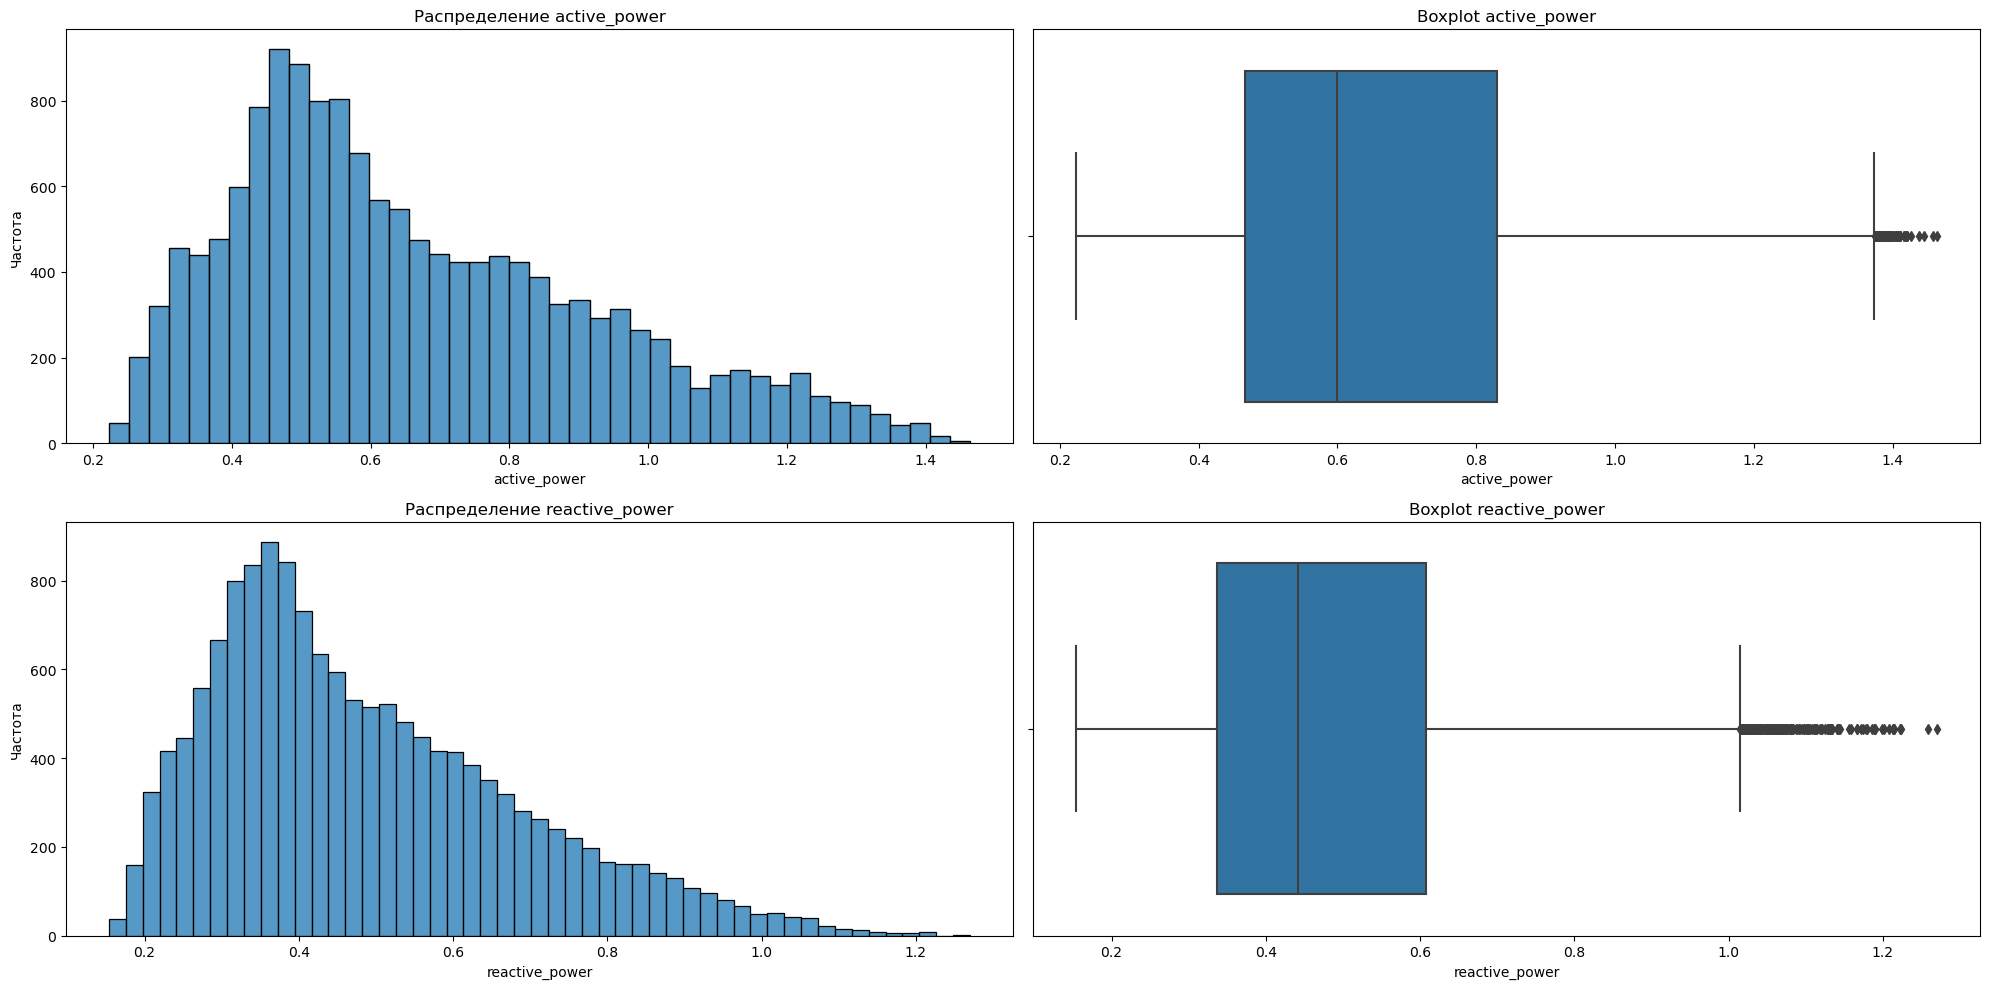

In [29]:
plot_distributions(data_arc, ['key', 'start_heating_arc', 'end_heating_arc'])

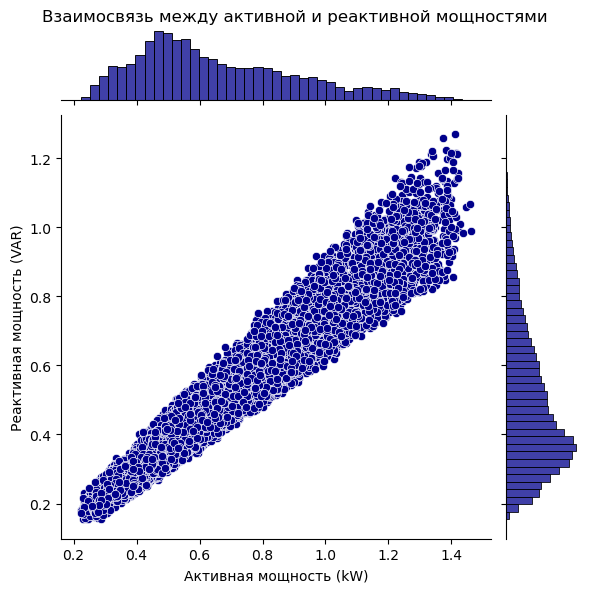

In [30]:
# Построение графика Зависимости 2 переменных
sns.jointplot(
    x=data_arc['active_power'], 
    y=data_arc['reactive_power'], 
    kind='scatter', 
    color='darkblue'
)

plt.suptitle('Взаимосвязь между активной и реактивной мощностями')
plt.xlabel('Активная мощность (kW)')
plt.ylabel('Реактивная мощность (VAR)')
plt.subplots_adjust(top=0.95)
plt.show()

**Вывод о распределении активной и реактивной мощности**

Распределение активной мощности (`active_power`):

1. **График рассеяния** показывает, что существует линейная зависимость между активной и реактивной мощностями. Большинство точек расположены вдоль наклонной линии, что свидетельствует о том, что при увеличении активной мощности возрастает и реактивная мощность.
2. **Ящик с усами (Boxplot)** для активной мощности указывает на наличие нескольких выбросов, которые находятся выше верхней границы усов. Это означает, что есть несколько значений активной мощности, которые значительно превышают типичные значения.
3. **Гистограмма** показывает, что распределение активной мощности имеет смещение вправо, с преобладанием значений в диапазоне от 0,4 до 0,8 кВт.

Распределение реактивной мощности (`reactive_power`):

1. **График рассеяния** также демонстрирует линейную зависимость между реактивной и активной мощностями, что логично, учитывая их взаимосвязь в контексте работы электрических систем.
2. **Ящик с усами (Boxplot)** для реактивной мощности указывает на наличие выбросов, но их количество меньше по сравнению с активной мощностью. Основная масса данных сосредоточена в диапазоне от 0,3 до 0,6 ВАР.
3. **Гистограмма** показывает, что распределение реактивной мощности также имеет смещение вправо, но в меньшей степени по сравнению с активной мощностью. Большинство значений находятся в диапазоне от 0,3 до 0,6 ВАР.

Выводы на основе статистической таблицы:

- **Средние значения** для активной и реактивной мощности составляют 0,6628 кВт и 0,4871 ВАР соответственно, что находится в пределах основной массы распределений.
- **Минимальные и максимальные значения** показывают, что разброс данных достаточно широк, особенно для активной мощности, где максимальное значение составляет 1,4638 кВт.
- **Стандартное отклонение** для активной мощности (0,2589 кВт) и реактивной мощности (0,1976 ВАР) указывает на умеренное рассеивание значений вокруг среднего, с несколькими экстремальными значениями, о чем свидетельствуют выбросы на графиках.

В целом, активная и реактивная мощности демонстрируют нормальные распределения с некоторым количеством выбросов. \
Взаимосвязь между ними прослеживается четко и логично в контексте работы электрических систем, где увеличение активной мощности обычно сопровождается увеличением реактивной мощности.


#### Генерация новых признаков

1. **Полная мощность (Apparent Power)**

**Полная мощность** (также известная как **аппаратная мощность**) \
в электрических цепях представляет собой векторную сумму активной и реактивной мощностей. \
Полная мощность обозначается как $S$ и измеряется в вольт-амперах (ВА).

Полная мощность рассчитывается по **Формуле:**

$$
S = \sqrt{P^2 + Q^2}
$$

где:
- $P$ — активная мощность, измеряемая в ваттах (W).
- $Q$ — реактивная мощность, измеряемая в вольт-амперах реактивных (VAR).

2. **Коэффициент мощности (Power Factor)**

**Коэффициент мощности** (Power Factor) — это косинус угла $\phi$, \
который характеризует фазовый сдвиг между векторами полной и активной мощности. \
Он показывает, какая часть полной мощности используется для выполнения полезной работы.

Коэффициент мощности рассчитывается **Формуле:**

$$
\text{Power Factor} = \cos(\phi) = \frac{P}{S}
$$

где:
- $P$ — активная мощность (W).
- $S$ — полная мощность (ВА).

**Связь между активной, реактивной и полной мощностями**

Активная мощность $P$ выполняет полезную работу, тогда как реактивная мощность $Q$ не выполняет полезной работы, \
но необходима для поддержания электрических и магнитных полей в цепи. \
Полная мощность $S$ представляет собой сумму этих двух компонент.

Величина коэффициента мощности может варьироваться от 0 до 1:
- Если коэффициент мощности близок к 1, это означает,\
 что почти вся мощность используется для выполнения полезной работы.
 
- Если коэффициент мощности близок к 0, это означает, что значительная часть мощности теряется на поддержание полей,\
 и эффективность системы низкая.

Коэффициент мощности является важным показателем эффективности электрической системы.\
Чем выше коэффициент мощности, тем лучше используется энергия. \
В идеале, система должна иметь коэффициент мощности, близкий к 1, что свидетельствует о минимальных потерях и высокой эффективности.

3. **Длительность нагрева (`heating_duration`)**

heating_duration показывает время, затраченное на нагрев стали в одном цикле. 

**Формула:**

$$
\text{heating\_duration} = \text{end\_heating\_arc} - \text{start\_heating\_arc}
$$

где:
- $\text{start\_heating\_arc}$ — начало нагрева.
- $\text{end\_heating\_arc}$ — окончание нагрева.


4. **Потребленная энергия (`energy_consumed`)**

energy_consumed оценивает количество энергии, затраченной на нагрев стали.\
В данном случае используется активная мощность, так как она представляет ту часть энергии,\
которая фактически используется для выполнения полезной работы — нагрева стали.

**Формула:**

$$
\text{energy\_consumed} = \text{active\_power} \times \text{heating\_duration}
$$

где:
- $\text{active\_power}$ — активная мощность (W).
- $\text{heating\_duration}$ — длительность нагрева (s).

5. **Изменение активной мощности (`power_diff`)** \
**Формула:**

$$
\text{power\_diff}_i = \text{active\_power}_i - \text{active\_power}_{i-1}
$$

где:
- $\text{active\_power}_i$ — активная мощность на текущем шаге,
- $\text{active\_power}_{i-1}$ — активная мощность на предыдущем шаге.

Этот признак помогает анализировать, как меняется активная мощность в процессе нагрева. \
Значительные изменения могут указывать на нестабильность процесса или на необходимость корректировки параметров нагрева.

6. **`heating_duration_diff` — Изменение длительности нагрева**
**Формула:**    

$$
\text{heating\_duration\_diff}_i = \text{heating\_duration}_i - \text{heating\_duration}_{i-1}
$$

где:
- $\text{heating\_duration}_i$ — длительность нагрева на текущем шаге,
- $\text{heating\_duration}_{i-1}$ — длительность нагрева на предыдущем шаге.

Этот признак показывает, как изменяется время, затраченное на нагрев на каждом этапе. \
Он может указывать на изменения в процессе, такие как увеличение или сокращение времени нагрева, \
что может влиять на качество конечного продукта.


7. **Размах (`range`) активной мощности**

Размах — это разница между максимальным и минимальным значением active_power для каждой партии. \
Он показывает абсолютное изменение мощности внутри партии.

**Формула:**

$$
\text{range} = \max(\text{active\_power}) - \min(\text{active\_power})
$$

где:
- $\text{range}$ — размах значений активной мощности для партии.
- $\max(\text{active\_power})$ — максимальное значение активной мощности в партии.
- $\min(\text{active\_power})$ — минимальное значение активной мощности в партии.


In [31]:
# 1 Рассчитываем полную мощность (аппаратную мощность)
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

# 2 Рассчитываем коэффициент мощности (cos(φ))
data_arc['power_factor'] = data_arc['active_power'] / data_arc['apparent_power']

# 3 Создаем новый признак "Длительность нагрева" в секундах
data_arc['heating_duration'] = (data_arc['end_heating_arc'] - data_arc['start_heating_arc']).dt.total_seconds()

# 4 Создаем новый признак energy_consumed
data_arc['energy_consumed'] = data_arc['apparent_power'] * data_arc['heating_duration']

# 5 6 Группируем данные по ключу 'key' и рассчитываем разницу длительности и энергии внутри каждой группы 
data_arc['power_diff'] = data_arc.groupby('key')['active_power'].diff()
data_arc['heating_duration_diff'] = data_arc.groupby('key')['heating_duration'].diff()

data_arc['power_diff'].fillna(0, inplace=True)
data_arc['heating_duration_diff'].fillna(0, inplace=True)

# 7 power_change + замена некорректных значений
data_arc['power_change'] = data_arc['power_diff'] / data_arc['heating_duration_diff']
data_arc['power_change'].replace([np.inf, -np.inf], 0, inplace=True)
data_arc['power_change'].fillna(0, inplace=True)

data_arc = data_arc.round(7) # округлим числа в таблице до 7го знака после запятой для экономии памяти

In [32]:
data_info(data_arc, 'Данные о дуговом нагреве ')


Таблица: Данные о дуговом нагреве 
Количество строк: 14876
Количество столбцов: 12
Первые 2 строки:


,key,start_heating_arc,end_heating_arc,active_power,reactive_power,apparent_power,power_factor,heating_duration,energy_consumed,power_diff,heating_duration_diff,power_change
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,0.822181,228.0,84.616003,0.000000,0.0,0.00000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,0.848545,185.0,166.928978,0.460528,-43.0,-0.01071


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   key                    14876 non-null  Int64         
 1   start_heating_arc      14876 non-null  datetime64[ns]
 2   end_heating_arc        14876 non-null  datetime64[ns]
 3   active_power           14876 non-null  float64       
 4   reactive_power         14876 non-null  float64       
 5   apparent_power         14876 non-null  float64       
 6   power_factor           14876 non-null  float64       
 7   heating_duration       14876 non-null  float64       
 8   energy_consumed        14876 non-null  float64       
 9   power_diff             14876 non-null  float64       
 10  heating_duration_diff  14876 non-null  float64       
 11  power_change           14876 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float

,key,active_power,reactive_power,apparent_power,power_factor,heating_duration,energy_consumed,power_diff,heating_duration_diff,power_change
count,14876.0,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.487118,0.823388,0.805887,171.670946,141.643890,0.001196,-7.425316,0.000159
std,934.571502,0.258885,0.197606,0.323459,0.027656,98.186803,103.197605,0.323609,125.053397,0.038876
min,1.0,0.223120,0.153777,0.275718,0.707722,11.000000,6.409531,-1.141089,-632.000000,-1.007414
25%,806.0,0.467115,0.337192,0.578847,0.788058,107.000000,71.158372,-0.158635,-69.000000,-0.001641
50%,1617.0,0.599587,0.441667,0.746591,0.809703,147.000000,114.462623,0.000000,0.000000,0.000000
75%,2429.0,0.830070,0.608201,1.030390,0.827038,214.000000,181.345716,0.165172,41.000000,0.001736
max,3241.0,1.463773,1.270284,1.898158,0.880503,907.000000,1084.729420,1.141188,670.000000,0.905876


In [33]:
agg_arc = data_arc.groupby('key').agg({
  'key' :  [('cycles', 'count')],
  'start_heating_arc': [('min')],
  'end_heating_arc': [('max')],
  'active_power': ['mean', 
                     'max', 
                     'min', 
                     'std', 
                     lambda x: x.max() - x.min()],

  'reactive_power': ['mean'],

  'apparent_power': ['mean', 
                     'max', 
                     'min', 
                     'std', 
                     lambda x: x.max() - x.min()],

  'power_factor': ['mean'],

  'heating_duration': ['sum', 
                       'std'],

  'energy_consumed': ['sum', 
                      'std'], 

  'power_diff': ['mean'],

  'heating_duration_diff': ['mean'],

  'power_change': ['mean', 
                   'max',
                   'min'] }).reset_index()

agg_arc = agg_arc.round(8)


# Переименование столбцов в одну логику
agg_arc.columns = [
    '_'.join(col).replace('<lambda_0>', 'range') 
    if isinstance(col, tuple) else col.replace('<lambda_0>', 'range') 
    for col in agg_arc.columns
]

agg_arc.rename(columns={'key_': 'key'}, inplace=True)
agg_arc.columns = [col.replace('<lambda_0>', 'range') for col in agg_arc.columns]
# agg_arc.loc[agg_arc['heating_duration_sum'] < 1700]
data_info(agg_arc.loc[agg_arc['heating_duration_sum'] < 1700], 'Агрегированные данные о подаче электричества')


Таблица: Агрегированные данные о подаче электричества
Количество строк: 3179
Количество столбцов: 25
Первые 2 строки:


,key,key_cycles,start_heating_arc_min,end_heating_arc_max,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,reactive_power_mean,...,power_factor_mean,heating_duration_sum,heating_duration_std,energy_consumed_sum,energy_consumed_std,power_diff_mean,heating_duration_diff_mean,power_change_mean,power_change_max,power_change_min
0,1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.867133,0.305130,0.219381,0.562003,0.428564,...,0.816686,1098.0,86.315120,770.282114,55.677795,0.112401,-16.00,0.000324,0.014257,-0.010710
1,2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.786322,0.261665,0.253168,0.524657,0.363339,...,0.825276,811.0,97.568352,481.760005,58.460457,0.101300,18.25,-0.000451,0.000905,-0.002116


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 0 to 3213
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   key                         3179 non-null   Int64         
 1   key_cycles                  3179 non-null   Int64         
 2   start_heating_arc_min       3179 non-null   datetime64[ns]
 3   end_heating_arc_max         3179 non-null   datetime64[ns]
 4   active_power_mean           3179 non-null   float64       
 5   active_power_max            3179 non-null   float64       
 6   active_power_min            3179 non-null   float64       
 7   active_power_std            3140 non-null   float64       
 8   active_power_range          3179 non-null   float64       
 9   reactive_power_mean         3179 non-null   float64       
 10  apparent_power_mean         3179 non-null   float64       
 11  apparent_power_max          3179 non-n

,key,key_cycles,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,reactive_power_mean,apparent_power_mean,apparent_power_max,...,power_factor_mean,heating_duration_sum,heating_duration_std,energy_consumed_sum,energy_consumed_std,power_diff_mean,heating_duration_diff_mean,power_change_mean,power_change_max,power_change_min
count,3179.0,3179.0,3179.000000,3179.000000,3179.000000,3140.000000,3179.000000,3179.000000,3179.000000,3179.000000,...,3179.000000,3179.000000,3140.000000,3179.000000,3140.000000,3179.000000,3179.000000,3179.000000,3179.000000,3179.000000
mean,1626.874174,4.574709,0.661346,0.960446,0.420754,0.236926,0.539692,0.486008,0.821601,1.195623,...,0.805905,780.339729,85.554131,644.104884,86.583238,0.001633,-7.001364,0.000149,0.017643,-0.016763
std,934.239414,1.510088,0.128704,0.231648,0.118799,0.101736,0.247458,0.097842,0.160526,0.291222,...,0.013979,301.051027,44.644278,283.799310,53.627953,0.090831,25.280393,0.017730,0.055526,0.056409
min,1.0,1.0,0.267676,0.267676,0.223120,0.001565,0.000000,0.196228,0.331897,0.331897,...,0.739789,57.000000,0.707107,33.430208,0.284173,-0.430439,-154.333333,-0.249296,0.000000,-1.007414
25%,824.5,4.0,0.572758,0.795606,0.331823,0.163016,0.356937,0.417191,0.710885,0.988673,...,0.797161,569.000000,53.928768,443.084090,50.081162,-0.048864,-16.500000,-0.002025,0.001065,-0.011443
50%,1626.0,4.0,0.652599,0.964806,0.406657,0.232709,0.542634,0.481334,0.812374,1.198112,...,0.806355,765.000000,79.108838,616.833492,75.802027,0.001599,-7.666667,0.000051,0.004152,-0.003990
75%,2437.5,5.5,0.739978,1.146756,0.479827,0.307684,0.724387,0.543653,0.917329,1.424244,...,0.815588,975.000000,107.344127,821.803184,111.379693,0.052191,2.387500,0.002373,0.012163,-0.000903
max,3241.0,14.0,1.243889,1.463773,1.140738,0.608732,1.141188,0.960763,1.572238,1.898158,...,0.857042,1689.000000,339.829369,2181.937459,492.271588,0.373682,219.000000,0.201461,0.905876,0.000000


#### **Вывод по исследовательскому анализу данных об электродах**

- Количество циклов (`cycles`): Позволяет оценить количество нагревательных циклов для каждой партии​
- Аппаратная мощность (`apparent_power`): Значительное рассеивание значений, указывающее на вариативность нагрузок системы.
- Коэффициент мощности (`power_factor`): Высокий уровень, свидетельствующий об эффективном использовании мощности.
- Длительность нагрева (`heating_duration`): Время нагрева варьируется, что влияет на стабильность процесса.
- Потребленная энергия (`energy_consumed`): Значительные колебания в энергопотреблении, указывающие на возможные неэффективности.
- Изменение мощности (`power_diff` и `power_change`): Анализ изменений мощности показывает важность стабильности процесса.
- Диапазон мощности (`power_range`): Варьирование мощностей требует внимания к пиковым нагрузкам и стабильности системы.

Процесс нагрева требует дальнейшего анализа и оптимизации для повышения стабильности и энергоэффективности.

**Агрегация таблицы**

В результате агрегации данных по партиям (`key`), мы получили сводную информацию по ключевым параметрам каждого производственного цикла:

- Количество циклов (`cycles`): Позволяет оценить количество нагревательных циклов для каждой партии.
- Средняя, максимальная и минимальная активная мощность (`active_power_mean`, `active_power_max`, `active_power_min`): Дают представление о типичных и крайних значениях мощности в процессе.
- Диапазон изменения активной и полной мощности (`active_power_range`, `apparent_power_range`): Помогает оценить амплитуду колебаний мощности, что важно для анализа стабильности процесса.
- Суммарное энергопотребление (`energy_consumed_sum`): Отражает общее количество энергии, затраченной на процесс для каждой партии.
- Среднее изменение мощности и продолжительности нагрева (`power_diff_mean`, `heating_duration_diff_mean`): Дают информацию о динамике изменений в процессе.

Агрегированные данные позволяют сделать выводы о стабильности и эффективности процессов нагрева, выявить возможные аномалии и области для оптимизации.


* В информации о некоторых партиях остались пропуски и выбросы, \
пока не будем избавляться от этих данных.
* Обработаем эти значения после финальной склейки таблиц,\
чтобы вести подсчет потереняного кол-ва данных.

### Таблицы `data_bulk`, `data_wire`, `data_gas`


Таблица: Данные о примесях
Количество строк: 3129
Количество столбцов: 15
Первые 2 строки:


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   252 non-null    float64
 1   bulk_2   22 non-null     float64
 2   bulk_3   1298 non-null   float64
 3   bulk_4   1014 non-null   float64
 4   bulk_5   77 non-null     float64
 5   bulk_6   576 non-null    float64
 6   bulk_7   25 non-null     float64
 7   bulk_8   1 non-null      float64
 8   bulk_9   19 non-null     float64
 9   bulk_10  176 non-null    float64
 10  bulk_11  177 non-null    float64
 11  bulk_12  2450 non-null   float64
 12  bulk_13  18 non-null     float64
 13  bulk_14  2806 non-null   float64
 14  bulk_15  2248 non-null   float64
dtypes: float64(15)
memory usage: 366.8 KB


,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


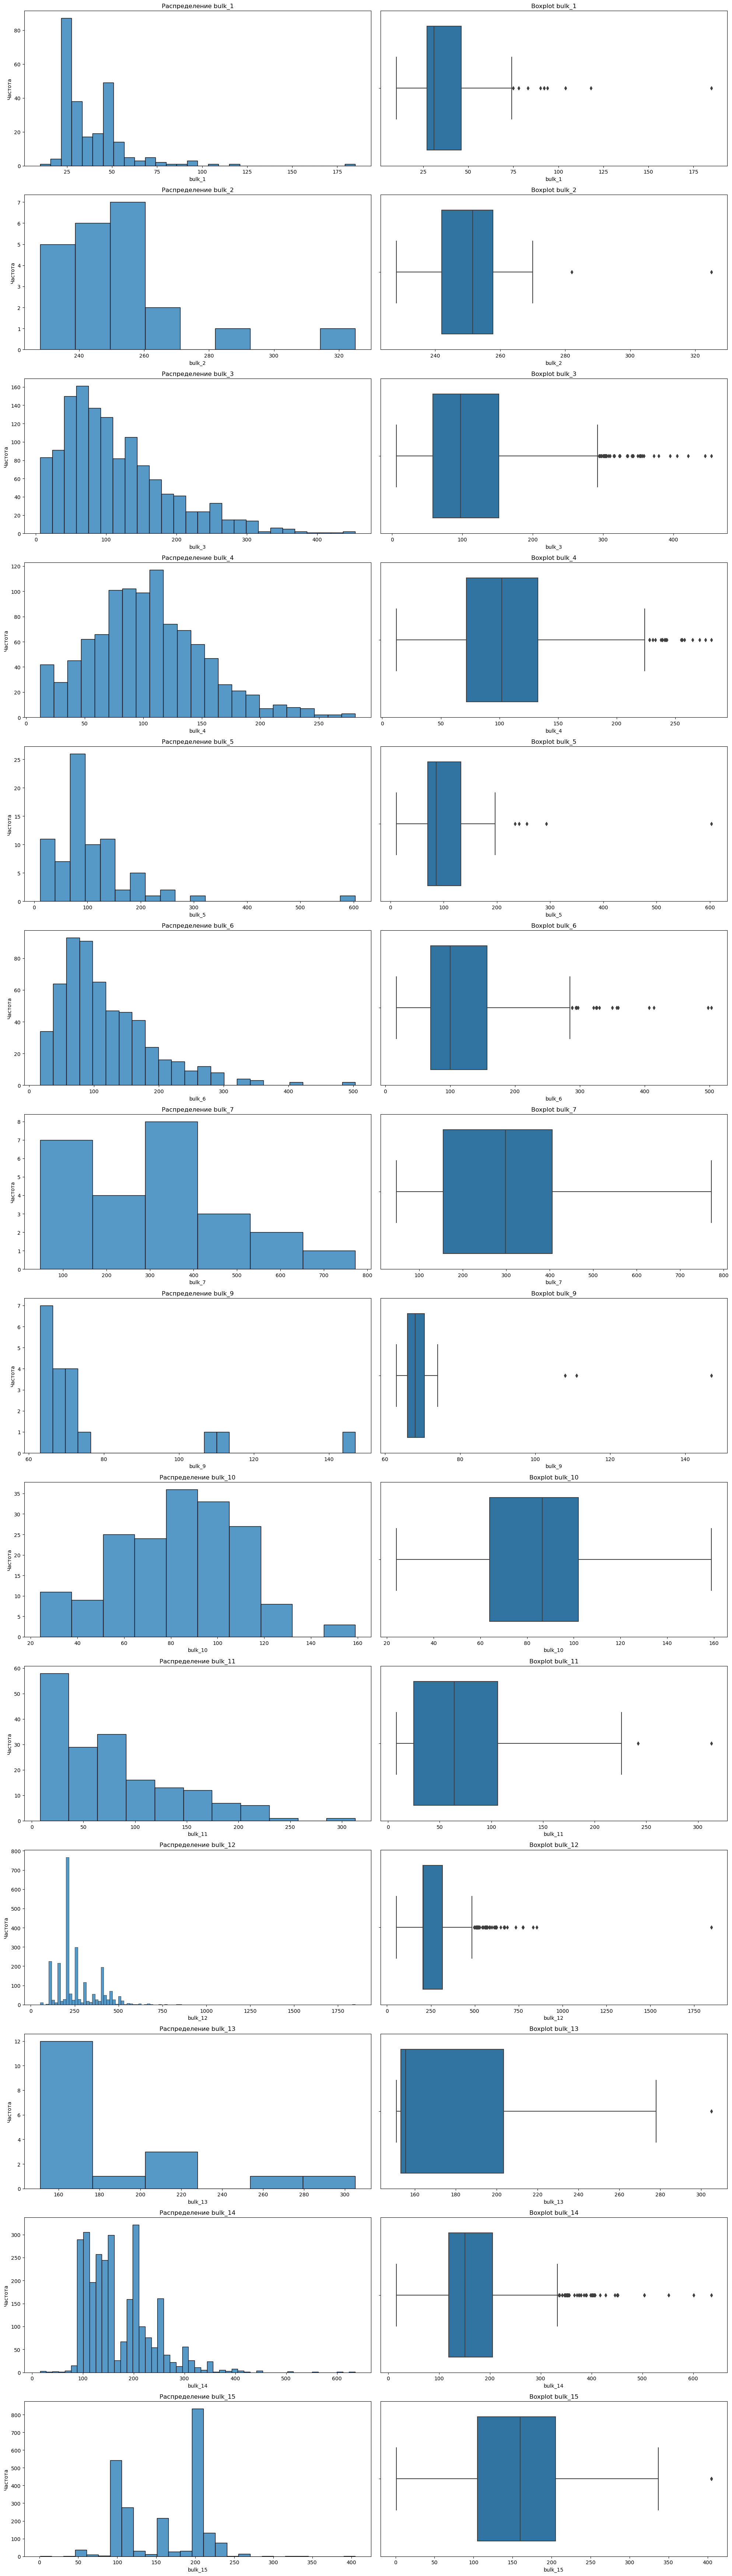

In [34]:
# для начала взгляним на таблицу data_bulk
data_info(data_bulk.drop('key', axis=1), 'Данные о примесях')
plot_distributions(data_bulk, exclude_columns=['key', 'bulk_8'])

**Выводы:**

- Неполнота данных: 

  - В таблице присутствуют значительные пропуски данных для некоторых переменных.\
  Например, столбцы `bulk_2`, `bulk_7`, `bulk_9`, `bulk_13` содержат крайне малое количество ненулевых значений, что может свидетельствовать о редком использовании этих материалов.
  - В дальнейшем пропуски будут заполнены 0, так как отсутсвие данных по какому либо материалу означает, что материал просто не использовался в партии.

- Распределение значений:
  - Большинство столбцов (например, `bulk_3`, `bulk_4`, `bulk_12`, `bulk_14`) имеют распределения, близкие к нормальному с умеренным смещением.

  - Столбцы `bulk_1`, `bulk_6`, и `bulk_10` демонстрируют более выраженное правостороннее смещение, что указывает на то, что большая часть значений находится в нижней части диапазона, а верхние значения встречаются редко.

- Варьирование значений:
  - Столбцы, такие как `bulk_5`, `bulk_6`, и `bulk_14`, имеют значительный разброс данных (высокое стандартное отклонение), что говорит о разнообразии используемых количеств материалов в этих категориях.

  - Для некоторых столбцов наблюдаются экстремальные значения (выбросы), например, `bulk_5` и `bulk_13`, что может указывать на аномалии в данных или на отдельные партии с уникальными условиями.

- Концентрация данных:
  - В таких столбцах, как `bulk_12` и `bulk_14`, наблюдается высокая концентрация данных в узком диапазоне значений, что может свидетельствовать о стандартизированном использовании этих материалов.
  - Столбец `bulk_3` показывает более равномерное распределение, что может говорить о более разнообразных условиях использования данного материала.

- Малое количество данных: 
    - В некоторых столбцах, таких как `bulk_2`, `bulk_6` и `bulk_13`, данные присутствуют в минимальных количествах, что затрудняет их анализ и требует осторожного подхода при интерпретации результатов.


Таблица: Данные о проволочных материалах
Количество строк: 3081
Количество столбцов: 9
Первые 2 строки:


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3055 non-null   float64
 1   wire_2  1079 non-null   float64
 2   wire_3  63 non-null     float64
 3   wire_4  14 non-null     float64
 4   wire_5  1 non-null      float64
 5   wire_6  73 non-null     float64
 6   wire_7  11 non-null     float64
 7   wire_8  19 non-null     float64
 8   wire_9  29 non-null     float64
dtypes: float64(9)
memory usage: 216.8 KB


,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


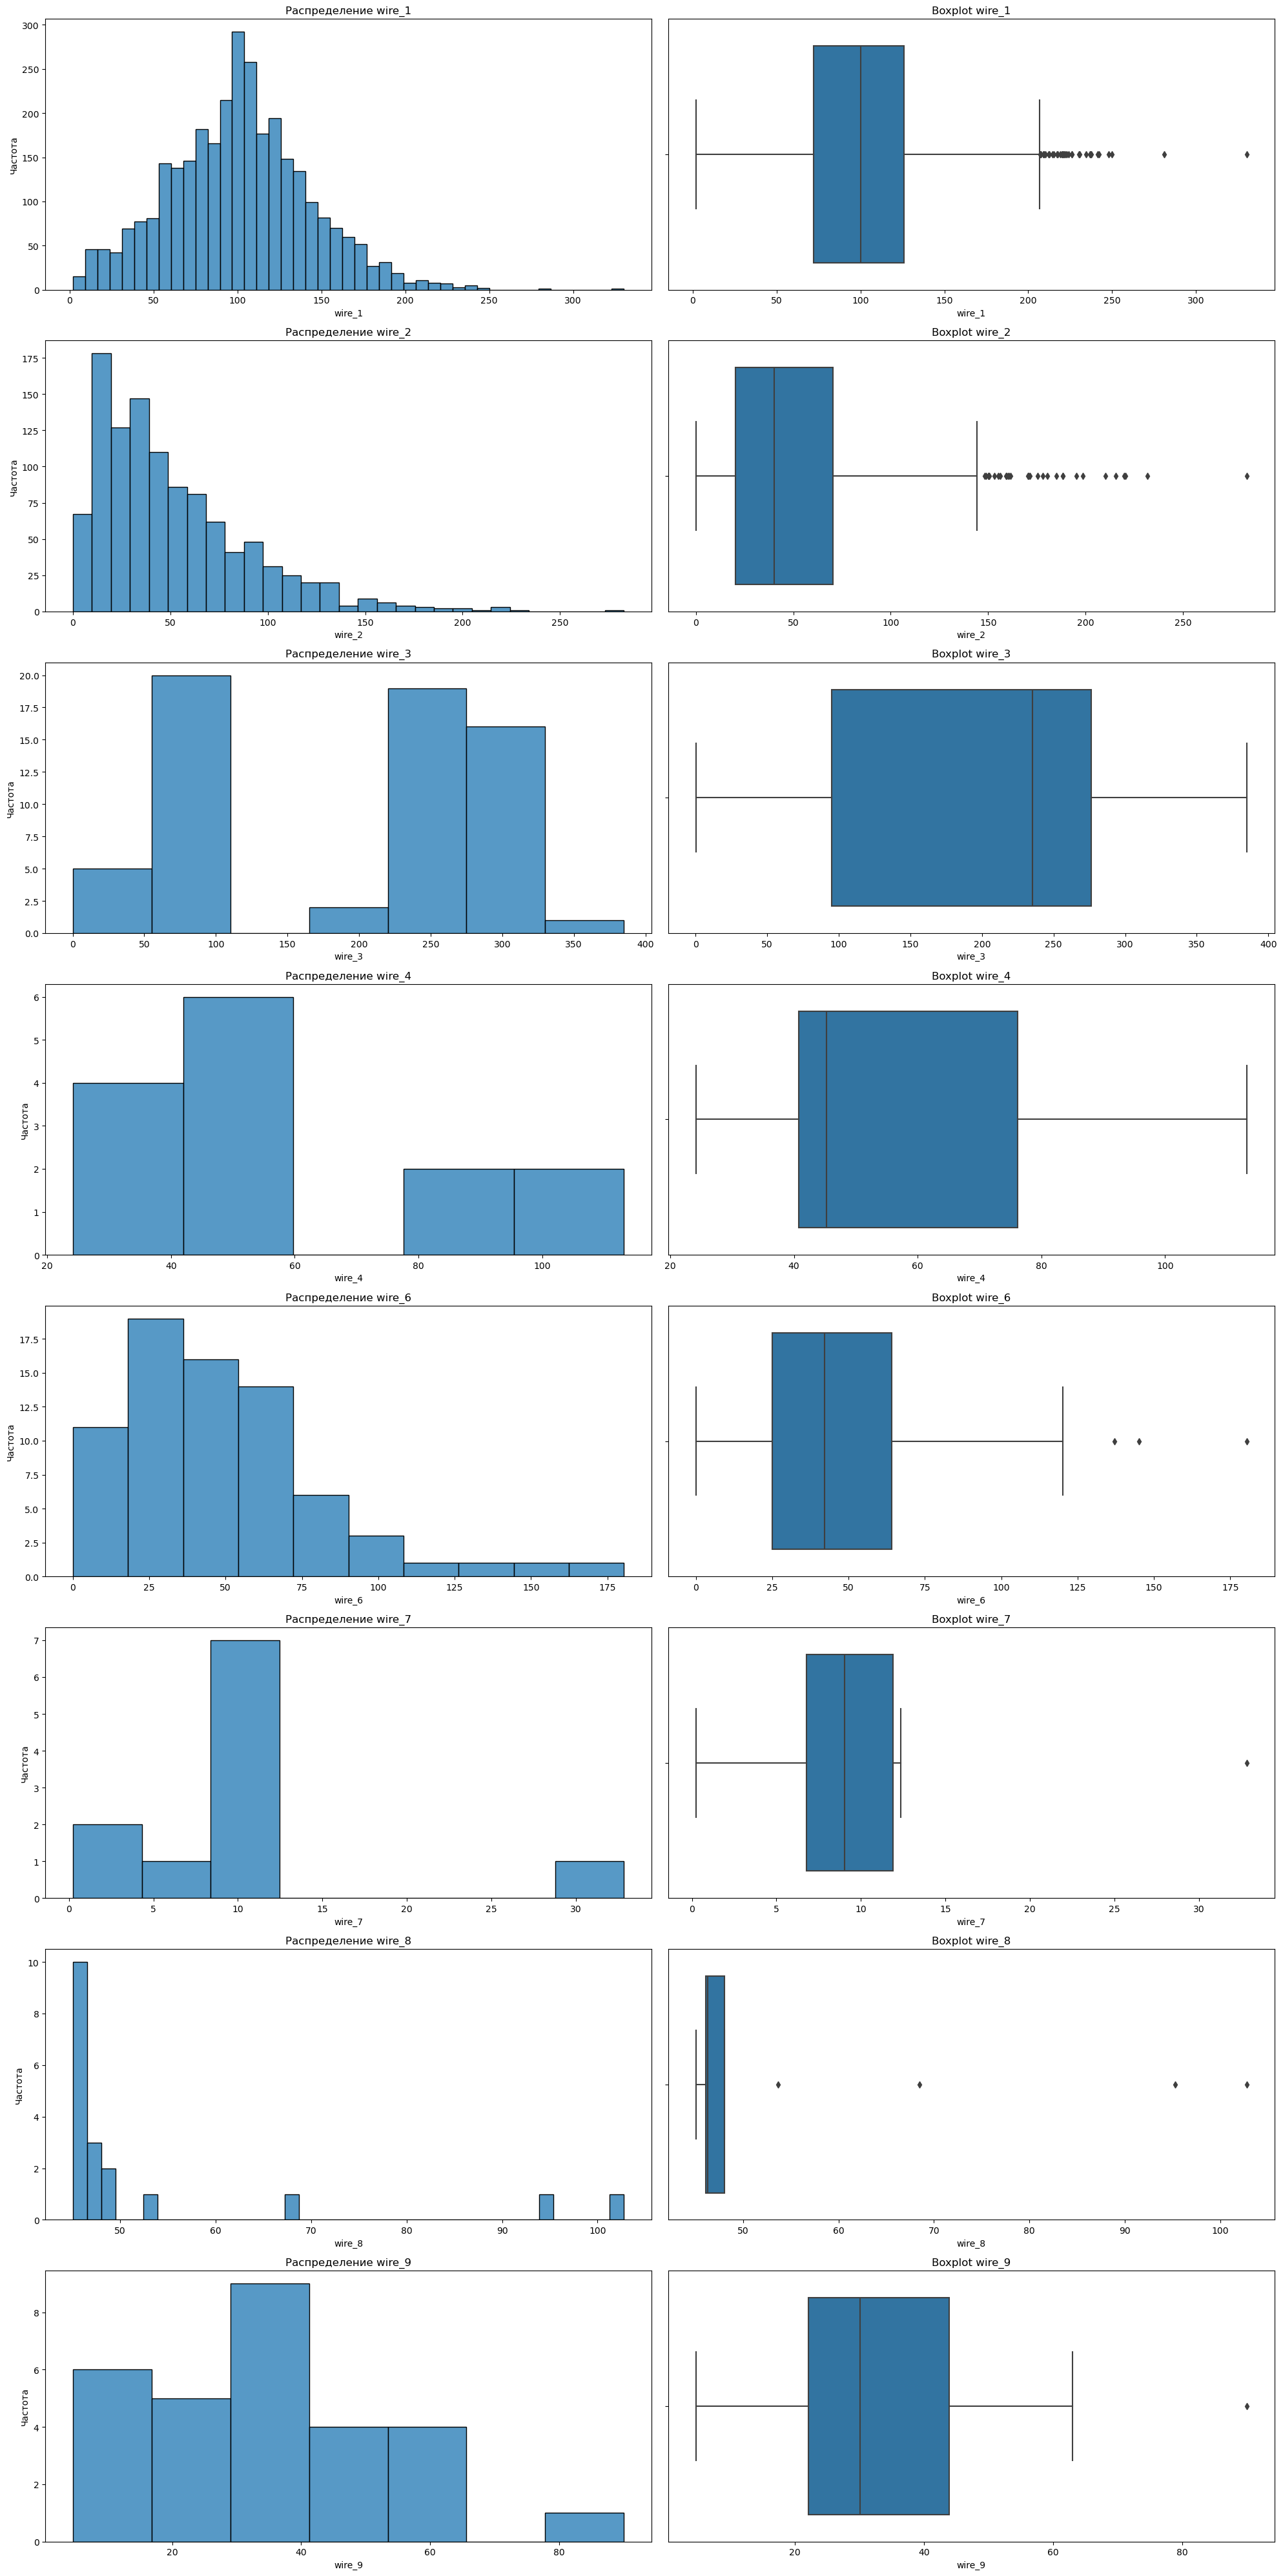

In [35]:
# Теперь посмотрим на данные таблицы data_wire 
data_info(data_wire.drop('key', axis=1), 'Данные о проволочных материалах')
plot_distributions(data_wire, exclude_columns=['wire_5','key'])

**Вывод о числовых распределениях в таблице проволочных материалов:**

- Неполнота данных: 
    - Как и в предыдущей таблице, в большинстве столбцов наблюдается значительное количество пропусков, особенно в столбцах `wire_3`, `wire_4`, `wire_5`, `wire_6`, `wire_7`, `wire_8`, и `wire_9`. \
    Столбец `wire_5` содержит только одно значение, что делает его нерелевантным для анализа.

- Распределение значений:
  - `wire_1` и `wire_2` имеют относительно нормальные распределения с правосторонним смещением, что указывает на более частое использование меньших объемов этих материалов.
  - Для других столбцов, таких как `wire_3`, `wire_4`, и `wire_6`, наблюдаются более хаотичные распределения с несколькими пиками, что может свидетельствовать о нерегулярности использования этих материалов.

- Варьирование значений:
  - Столбцы `wire_1` и `wire_3` показывают значительное варьирование данных (высокое стандартное отклонение), что указывает на разнообразие в количестве используемых проволочных материалов в этих категориях.
  - Столбцы `wire_4` и `wire_7` имеют меньший разброс данных, что говорит о более стандартизированном использовании этих материалов.

- Выбросы: 
    - В некоторых столбцах, таких как `wire_1`, `wire_2`, и `wire_6`, на графиках Boxplot видно наличие выбросов, что может указывать на отдельные партии с необычно высокими объемами используемых материалов.

- Концентрация данных:
  - Столбцы `wire_1` и `wire_2` имеют значительную концентрацию данных в нижних диапазонах, что свидетельствует о частом использовании небольших объемов этих материалов.
  - В столбцах `wire_7`, `wire_8`, и `wire_9` данные сконцентрированы в узком диапазоне, что говорит о редком, но стандартизированном использовании этих материалов.

Распределение данных по столбцам указывает на значительное варьирование в количестве используемых проволочных материалов. \
Необходим дальнейший анализ для понимания причин высокой вариативности и выявления возможных аномалий в данных. \
Также стоит рассмотреть возможность исключения столбцов с крайне малым количеством данных из анализа.


Таблица: Данные о подаче газа
Количество строк: 3239
Количество столбцов: 1
Первые 2 строки:


,gas
0,29.749986
1,12.555561


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 25.4 KB


,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


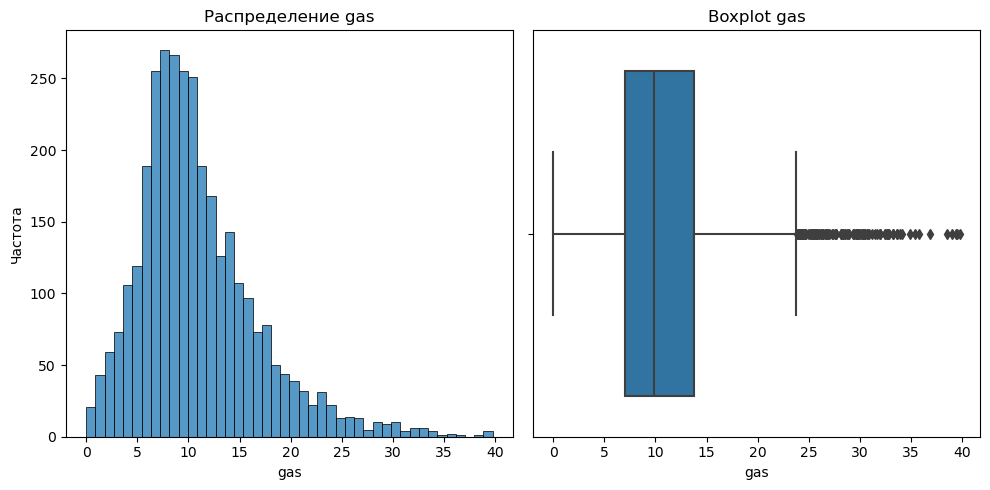

In [36]:
# Осталась последняя таблица data_gas
data_info(data_gas.drop('key', axis=1), 'Данные о подаче газа')
plot_distributions(data_gas.loc[data_gas['gas'] < 40], exclude_columns=['key']) # чтобы оценить данные без выбросов

**Вывод о распределении значений в таблице data_gas**

  - В таблице отсутсвуют пропуски.
  - Гистограмма распределения показывает, что значения переменной gas имеют правостороннее смещение.\
  Большинство значений сконцентрированы в диапазоне от 0 до 20, при этом очень малое количество значений превышает этот предел.
  - На гистограмме также видно, что основная масса данных сосредоточена в диапазоне от 0 до 20, \
  что подтверждается резким снижением частоты значений по мере увеличения объема газа.
  - Среднее значение объема газа составляет 11.0021 единиц, что находится ближе к нижней границе диапазона данных.
  - Стандартное отклонение (6.2203) указывает на значительную вариативность данных, что видно также из наличия выбросов.
  - Минимальное значение объема газа — 0.0084, а максимальное значение достигает 77.9950, что говорит о присутствии нескольких выбросов в данных.
  - Медианное значение (50-й процентиль) равно 9.8363, что подтверждает, что большая часть данных сосредоточена ниже среднего значения.
  - Переменная gas демонстрирует правостороннее смещение с концентрацией данных в нижнем диапазоне значений.\
  Наличие выбросов требует дальнейшего анализа, чтобы определить их природу — возможно, это аномалии или особые условия процесса.

#### Склейка таблиц, создание нового признака.

Поскольку 3 таблицы имеют достаточно схожую структуру, которая хранит информацию о кол-ве подаваемого сырья. \
Мы создадим общую таблицу, которая будет содержать информацию о всех используемых примесях. 

In [37]:
# для начала избавимся от пропусков в данных заменив их на 0

data_bulk, data_wire = fill_na_with_zero(data_bulk, data_wire)

print(f'Пропусков в таблицах: \
      {data_bulk.isna().sum().sum()}\
      и           {data_wire.isna().sum().sum()}')

Пропусков в таблицах:       0      и           0


In [38]:
# data_addons['bulk_additions_count'] = (data_bulk.drop(columns=['key']) > 0).sum(axis=1)

In [39]:
# Склейка таблиц по ключу 'key'
data_addons = pd.merge(data_bulk, data_wire, on='key', suffixes=('_bulk', '_wire'))
data_addons = pd.merge(data_addons, data_gas, on='key', suffixes=('_bulk', '_wire'))


In [40]:
# Склейка таблиц по ключу 'key' с сохранением всех уникальных ключей
data_addons = pd.merge(data_bulk, data_wire, on='key', how='outer', suffixes=('_bulk', '_wire'))
data_addons = pd.merge(data_addons, data_gas, on='key', how='outer')

# Создание столбцов для суммы значений и кол-во общих добавок в таблицах data_bulk и data_wire
data_addons['bulk_sum'] = data_addons.filter(like='bulk_').sum(axis=1)
data_addons['wire_sum'] = data_addons.filter(like='wire_').sum(axis=1)

# Для таблицы data_wire
data_addons['wire_add_count'] = (data_addons.drop(columns=['key', 'bulk_sum']) > 0).filter(like='bulk_').sum(axis=1)
data_addons['bulk_add_count'] = (data_addons.drop(columns=['key', 'wire_sum']) > 0).filter(like='wire_').sum(axis=1)


# Создание столбца, который суммирует значения bulk_sum и wire_sum
data_addons['added_sum'] = data_addons['bulk_sum'] + data_addons['wire_sum']
data_addons['add_count_total'] = data_addons['wire_add_count'] + data_addons['bulk_add_count']


In [41]:
data_addons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3241 non-null   Int64  
 1   bulk_1           3129 non-null   float64
 2   bulk_2           3129 non-null   float64
 3   bulk_3           3129 non-null   float64
 4   bulk_4           3129 non-null   float64
 5   bulk_5           3129 non-null   float64
 6   bulk_6           3129 non-null   float64
 7   bulk_7           3129 non-null   float64
 8   bulk_8           3129 non-null   float64
 9   bulk_9           3129 non-null   float64
 10  bulk_10          3129 non-null   float64
 11  bulk_11          3129 non-null   float64
 12  bulk_12          3129 non-null   float64
 13  bulk_13          3129 non-null   float64
 14  bulk_14          3129 non-null   float64
 15  bulk_15          3129 non-null   float64
 16  wire_1           3081 non-null   float64
 17  wire_2        

In [42]:
data_addons,  data_bulk= fill_na_with_zero(data_addons, data_bulk)



Таблица: Данные о проволочных материалах
Количество строк: 3241
Количество столбцов: 32
Первые 2 строки:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,...,wire_7,wire_8,wire_9,gas,bulk_sum,wire_sum,wire_add_count,bulk_add_count,added_sum,add_count_total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,29.749986,553.0,60.059998,4,2,613.059998,6
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.555561,582.0,96.052315,4,2,678.052315,6


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3241 non-null   Int64  
 1   bulk_1           3241 non-null   float64
 2   bulk_2           3241 non-null   float64
 3   bulk_3           3241 non-null   float64
 4   bulk_4           3241 non-null   float64
 5   bulk_5           3241 non-null   float64
 6   bulk_6           3241 non-null   float64
 7   bulk_7           3241 non-null   float64
 8   bulk_8           3241 non-null   float64
 9   bulk_9           3241 non-null   float64
 10  bulk_10          3241 non-null   float64
 11  bulk_11          3241 non-null   float64
 12  bulk_12          3241 non-null   float64
 13  bulk_13          3241 non-null   float64
 14  bulk_14          3241 non-null   float64
 15  bulk_15          3241 non-null   float64
 16  wire_1           3241 non-null   floa

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,...,wire_7,wire_8,wire_9,gas,bulk_sum,wire_sum,wire_add_count,bulk_add_count,added_sum,add_count_total
count,3241.0,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,...,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000
mean,1621.0,3.051219,1.717680,45.607837,32.661524,2.542734,21.135761,2.357297,0.015119,0.447393,...,0.034073,0.314372,0.305621,10.995273,574.924406,117.615417,3.443073,2.305770,692.539823,5.748843
std,935.740438,11.676497,20.850457,73.454237,55.403279,20.559041,54.671494,31.390257,0.860709,6.047683,...,0.754873,4.283442,3.712369,6.224408,292.703445,69.784756,1.361026,0.695218,308.208407,1.657340
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,811.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.037024,407.000000,80.196480,3.000000,2.000000,511.149680,5.000000
50%,1621.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.828795,583.000000,110.213997,4.000000,2.000000,701.063194,6.000000
75%,2431.0,0.000000,0.000000,75.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,13.767872,764.000000,147.632157,4.000000,3.000000,895.693664,7.000000
max,3241.0,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,...,32.847674,102.762401,90.053604,77.995040,3235.000000,663.851766,7.000000,6.000000,3423.228550,11.000000


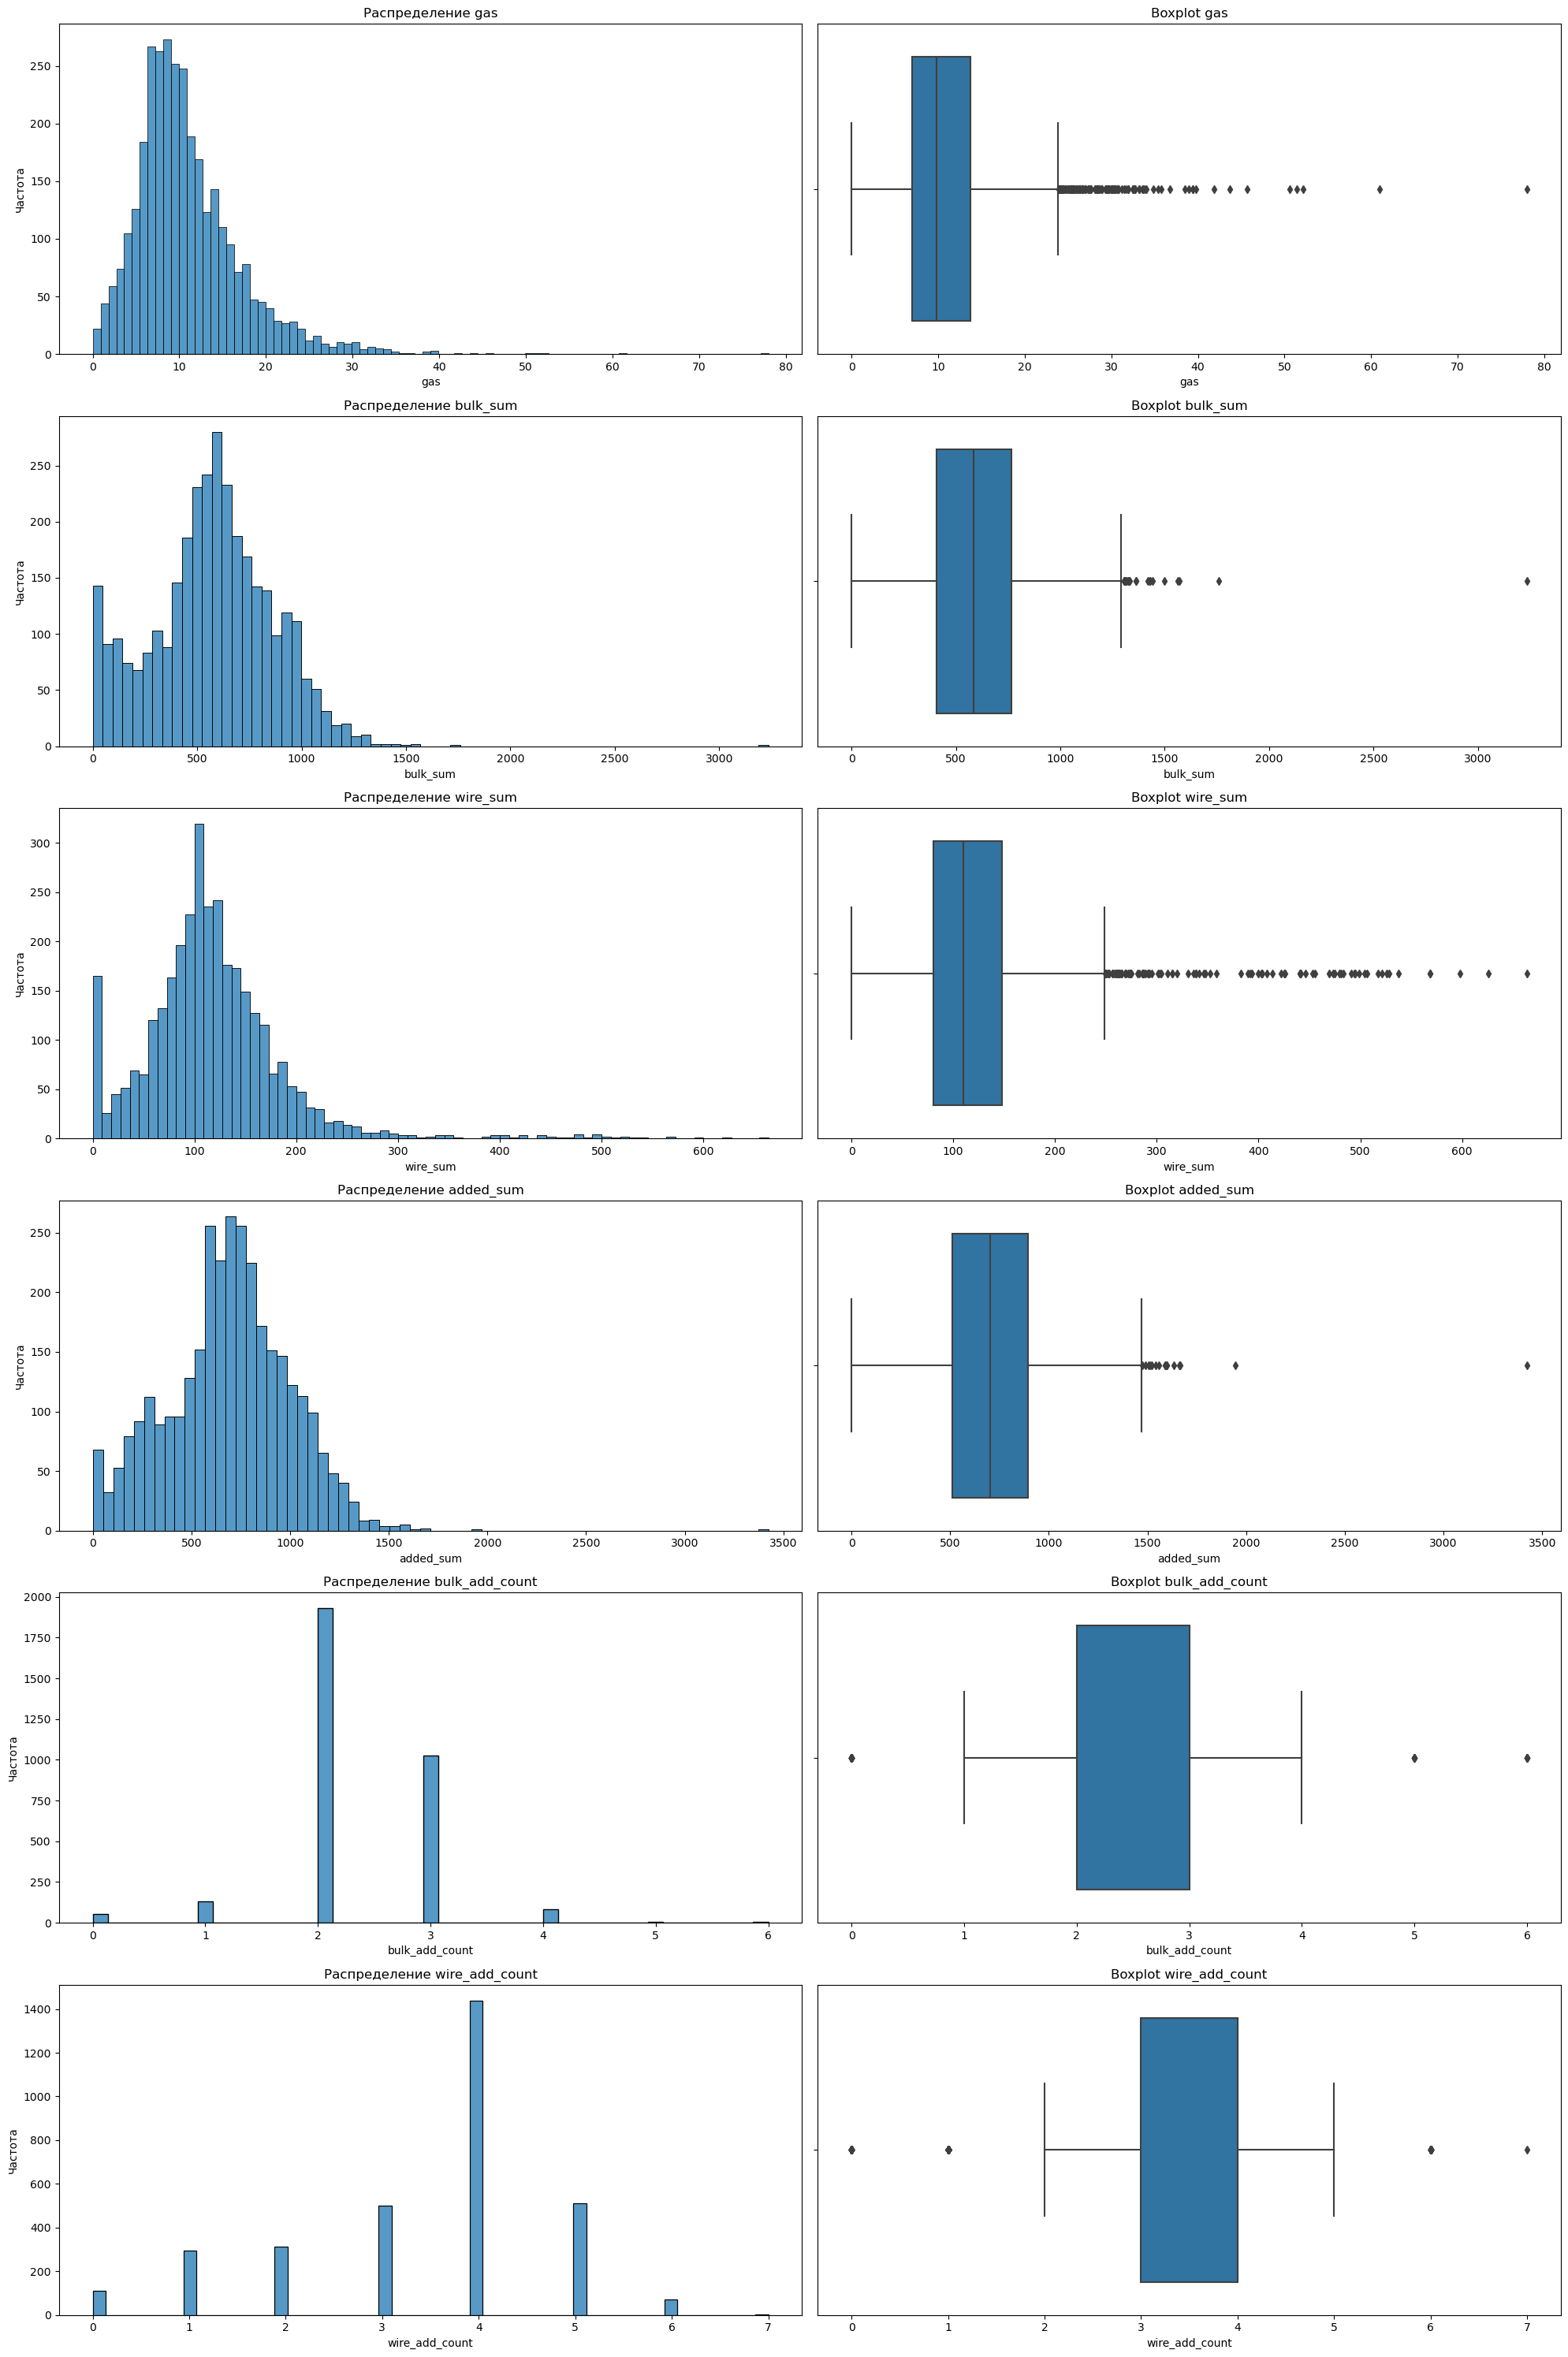

In [43]:
data_info(data_addons, 'Данные о проволочных материалах')
plot_distributions(data_addons[['gas',
                                'bulk_sum', 
                                'wire_sum', 
                                'added_sum', 
                                'bulk_add_count', 
                                'wire_add_count']])

In [44]:
# Еще раз посмотрим сколько разные добавки были использованы во всех партиях
def count_non_zero_values(dataframe):
    non_zero_counts = (dataframe != 0).sum()
    return non_zero_counts

non_zero_counts_wire = count_non_zero_values(data_addons)
print("Количество использований примесей к стали:")
display(non_zero_counts_wire)


Количество использований примесей к стали:


key                3241
bulk_1              252
bulk_2               22
bulk_3             1298
bulk_4             1014
bulk_5               77
bulk_6              576
bulk_7               25
bulk_8                1
bulk_9               19
bulk_10             176
bulk_11             177
bulk_12            2450
bulk_13              18
bulk_14            2806
bulk_15            2248
wire_1             3055
wire_2             1079
wire_3               63
wire_4               14
wire_5                1
wire_6               73
wire_7               11
wire_8               19
wire_9               29
gas                3239
bulk_sum           3129
wire_sum           3081
wire_add_count     3129
bulk_add_count     3185
added_sum          3185
add_count_total    3185
dtype: Int64

Сгруппируем в общей таблице неинформативные признаки.\
Создадим `bulk_other` и `wire_other` и установим порог количества использований каждой примеси и проволоки в 24 и 30 повторений соотетсвенно.\
Если примесь или проволока используется меньше порога, она попадет в столбец `_other`

In [45]:
data_addons = consolidate_columns(data_addons, bulk_threshold=24, wire_threshold=30)

In [46]:
data_info(data_addons, 'Данные о газе, сыпучих и проволочных добавках')


Таблица: Данные о газе, сыпучих и проволочных добавках
Количество строк: 3241
Количество столбцов: 25
Первые 2 строки:


,key,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_10,bulk_11,bulk_12,...,wire_6,gas,bulk_sum,wire_sum,wire_add_count,bulk_add_count,added_sum,add_count_total,bulk_other,wire_other
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,...,0.0,29.749986,553.0,60.059998,4,2,613.059998,6,0.0,0.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,...,0.0,12.555561,582.0,96.052315,4,2,678.052315,6,0.0,0.0


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3241 non-null   Int64  
 1   bulk_1           3241 non-null   float64
 2   bulk_3           3241 non-null   float64
 3   bulk_4           3241 non-null   float64
 4   bulk_5           3241 non-null   float64
 5   bulk_6           3241 non-null   float64
 6   bulk_7           3241 non-null   float64
 7   bulk_10          3241 non-null   float64
 8   bulk_11          3241 non-null   float64
 9   bulk_12          3241 non-null   float64
 10  bulk_14          3241 non-null   float64
 11  bulk_15          3241 non-null   float64
 12  wire_1           3241 non-null   float64
 13  wire_2           3241 non-null   float64
 14  wire_3           3241 non-null   float64
 15  wire_6           3241 non-null   float64
 16  gas              3241 non-null   floa

,key,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_10,bulk_11,bulk_12,...,wire_6,gas,bulk_sum,wire_sum,wire_add_count,bulk_add_count,added_sum,add_count_total,bulk_other,wire_other
count,3241.0,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,...,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000
mean,1621.0,3.051219,45.607837,32.661524,2.542734,21.135761,2.357297,4.522678,4.195310,196.900339,...,1.081530,10.995273,574.924406,117.615417,3.443073,2.305770,692.539823,5.748843,3.186054,0.906867
std,935.740438,11.676497,73.454237,55.403279,20.559041,54.671494,31.390257,19.824341,22.317915,153.373717,...,8.737601,6.224408,292.703445,69.784756,1.361026,0.695218,308.208407,1.657340,25.746358,7.152114
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,811.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,...,0.000000,7.037024,407.000000,80.196480,3.000000,2.000000,511.149680,5.000000,0.000000,0.000000
50%,1621.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,...,0.000000,9.828795,583.000000,110.213997,4.000000,2.000000,701.063194,6.000000,0.000000,0.000000
75%,2431.0,0.000000,75.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,259.000000,...,0.000000,13.767872,764.000000,147.632157,4.000000,3.000000,895.693664,7.000000,0.000000,0.000000
max,3241.0,185.000000,454.000000,281.000000,603.000000,503.000000,772.000000,159.000000,313.000000,1849.000000,...,180.454575,77.995040,3235.000000,663.851766,7.000000,6.000000,3423.228550,11.000000,325.000000,118.266516


* Добавлены новые признаки.
* При исследовании итоговой таблицы все выбросы будут обработаны.

### Таблицы `data_bulk_time` И `data_wire_time`

Данные содержат информацию о времени подачи той или иной добавки в сплав.\
Для того чтобы проверить данные на адекватность соеденим 2 таблицы и расчитаем общую длительность для каждой партии.

In [47]:
# Объединяем таблицы по ключу 'key'
data_time = pd.merge(data_bulk_time, data_wire_time, on='key', how='outer')

# Преобразуем все столбцы, содержащие время, в формат datetime
time_columns = data_time.columns.drop('key')
for col in time_columns:
    data_time[col] = pd.to_datetime(data_time[col], errors='coerce')

# Найдем минимальное и максимальное время для каждой строки (партии)
data_time['start_time'] = data_time[time_columns].min(axis=1)
data_time['end_time'] = data_time[time_columns].max(axis=1)

# Рассчитаем длительность как разницу между максимальным и минимальным временем
data_time['duration'] = (data_time['end_time'] - data_time['start_time'])#.dt.total_seconds()

# Результат
display(data_time[['key', 'start_time', 'end_time', 'duration']].sort_values(by='duration', ascending=False).head(5))

,key,start_time,end_time,duration
1895,1958,2019-07-21 10:04:47,2019-07-21 14:44:03,0 days 04:39:16
611,641,2019-05-28 03:57:11,2019-05-28 08:31:58,0 days 04:34:47
767,801,2019-06-03 14:56:10,2019-06-03 18:20:58,0 days 03:24:48
1819,1881,2019-07-12 10:33:08,2019-07-12 13:55:14,0 days 03:22:06
2036,2108,2019-07-27 13:43:32,2019-07-27 16:34:15,0 days 02:50:43


Данные о партиях адекватные, максимальная длительность добавки примесей составляет 4 часа.\
Из наблюдаемой таблицы `data_time` можно вывести информацию о последовательности добавления сыпучих примесей и проволоки.\
Создадим таблицу которая будет содержать данные о последовательности добавок.\
В итоге, у нас должен получиться вектор признаков для каждой партии в формате:\
(0, 4, 7, 0 , 0, ..., 2, 1) - где число это порядок примеси.

In [48]:
# Применим функцию к каждой строке (партии)
order_data = data_time[time_columns].apply(calculate_order, axis=1).fillna('0', axis=1)

# Присоединим результаты к исходной таблице
order_data = pd.concat([data_time[['key', 'start_time', 'end_time']], order_data.add_suffix('_order')], axis=1)
display(order_data.sample())

,key,start_time,end_time,bulk_time_1_order,bulk_time_2_order,bulk_time_3_order,bulk_time_4_order,bulk_time_5_order,bulk_time_6_order,bulk_time_7_order,...,bulk_time_15_order,wire_time_1_order,wire_time_2_order,wire_time_3_order,wire_time_4_order,wire_time_5_order,wire_time_6_order,wire_time_7_order,wire_time_8_order,wire_time_9_order
412,438,2019-05-20 04:00:26,2019-05-20 04:45:39,0,0,0,6.0,0,0,0,...,3.0,2.0,1.0,0,0,0,0,0,0,0


Проверим производительность цеха

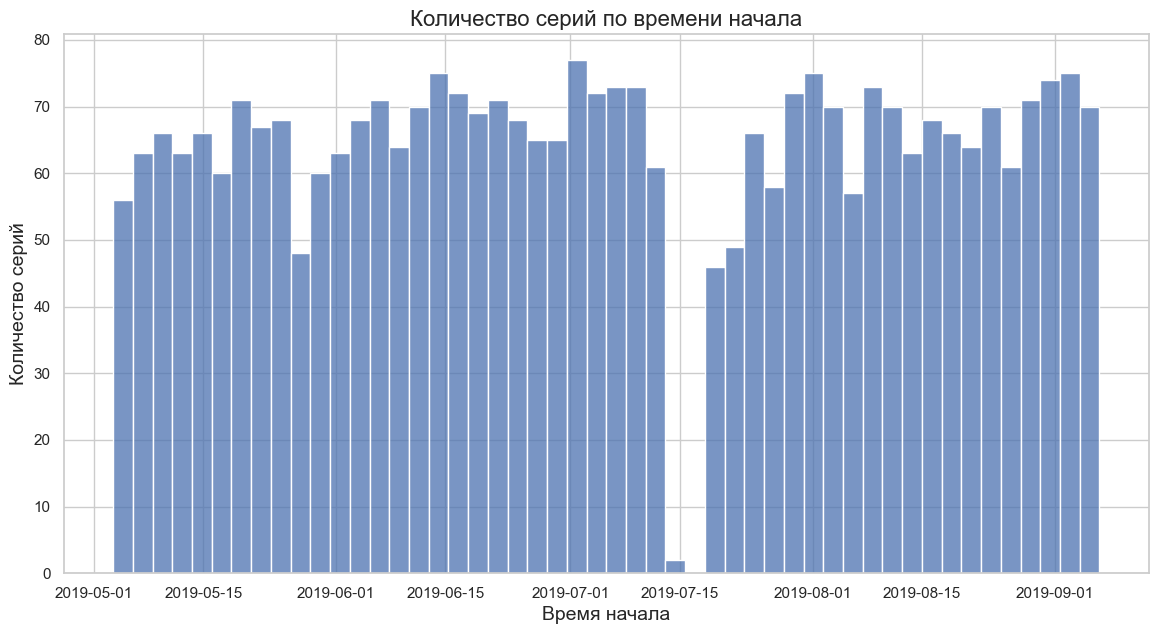

In [49]:
# Убедимся, что данные отсортированы по времени начала
data_time_sorted = data_time.sort_values('start_time')

# Устанавливаем стиль графика
sns.set(style="whitegrid")

# Построение графика распределения количества серий по времени
plt.figure(figsize=(14, 7))
sns.histplot(data_time_sorted['start_time'], bins=50, kde=False)

# Настройка осей и заголовков
plt.title('Количество серий по времени начала', fontsize=16)
plt.xlabel('Время начала', fontsize=14)
plt.ylabel('Количество серий', fontsize=14)

# Отображение графика
plt.show()
del data_time_sorted

**ВЫВОД:**
- На графике наблюдается технический сбой в производстве\
производство точно останавливалось или не фискировались данные.
- Из таблиц содержащих временные метки подачи каждой примеси выделели:
    - Время использования первой и последней добавки в рамках серии;
    - Порядок внесения примесей в рамках серии.

### Таблица `data_temp`


Таблица: Данные о температуре
Количество строк: 18092
Количество столбцов: 2
Первые 2 строки:


,measurement_time,temperature
0,2019-05-03 11:02:04,1571.0
1,2019-05-03 11:07:18,1604.0


Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   measurement_time  18092 non-null  datetime64[ns]
 1   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 282.8 KB


,temperature
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


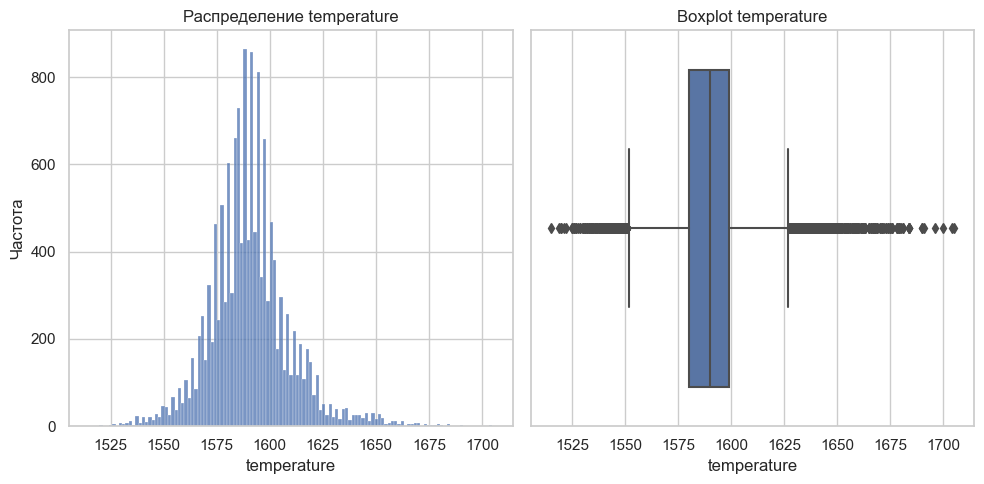

In [50]:
data_info(data_temp[['measurement_time', 'temperature']], 'Данные о температуре')
plot_distributions(data_temp.loc[data_temp['temperature'] > 1500], ['key', 'measurement_time']) # посмотрим на распределение температуры без аномалий

**Вывод по распределению `temperature`:**
- Присутсвуют некорректные значения для условий задачи - температура ниже 1500.
- Среднее значение температуры: 1590.72°C
- Стандартное отклонение: 20.39°C, что указывает на небольшой разброс значений вокруг среднего.
- Минимальное значение: 1191°C, что может указывать на наличие аномальных значений.
- Максимальное значение: 1705°C
- Медиана: 1590°C, что близко к среднему значению.

Распределение температуры приближается к нормальному, но существуют выбросы, особенно в нижней части распределения.

#### Проверка корректности замера температуры

В данных о температуре присутсвуют пропуски.\
Так как мы знаем что бывает технический сбой на производстве - проверим,\
нет ли зависимости от номера серии и пропуска в данных о температуре.

,key,measurement_time,temperature
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN


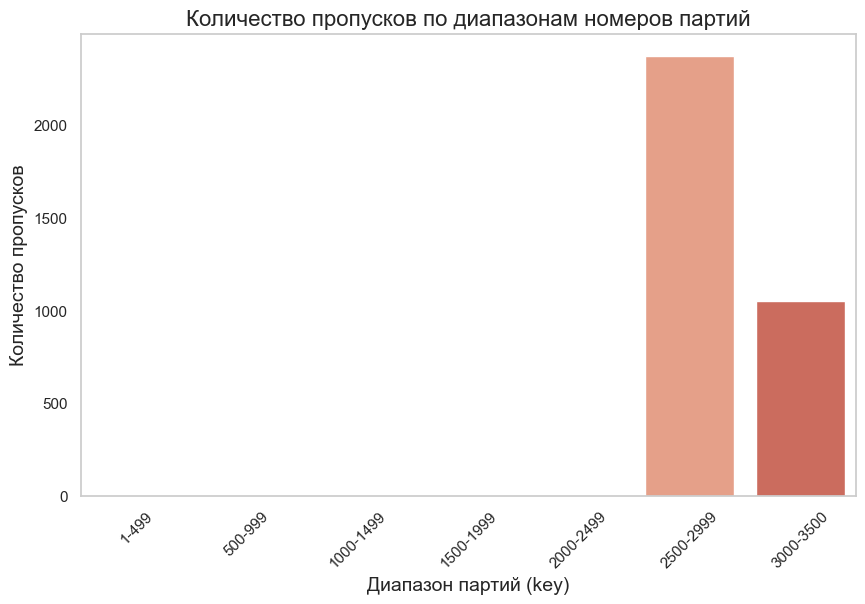

In [51]:
# Вспомогательные данные для анализа пропусков в замере температуры
missing_counts = data_temp.groupby('key')['temperature'].apply(lambda x: x.isna().sum()).reset_index()
missing_counts.columns = ['key', 'missing_count']
missing_counts['key_range'] = pd.cut(missing_counts['key'], 
                                     bins=[0, 499, 999, 1499, 1999, 2499, 2999, 3499],
                                     labels=['1-499', '500-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999','3000-3500'],
                                     right=False)
grouped_missing_counts = missing_counts.groupby('key_range')['missing_count'].sum().reset_index()
selected_keys = [2499, 2500, 2502]
filtered_data = data_temp[data_temp['key'].isin(selected_keys)]
filtered_data_sorted = filtered_data[['key', 'measurement_time', 'temperature']].sort_values(by=['key', 'measurement_time'])

# Вывод графика и таблицы ошибки замеров
display(filtered_data_sorted)
plt.figure(figsize=(10, 6))
sns.barplot(x='key_range', y='missing_count', data=grouped_missing_counts, palette='coolwarm')
plt.title('Количество пропусков по диапазонам номеров партий', fontsize=16)
plt.xlabel('Диапазон партий (key)', fontsize=14)
plt.ylabel('Количество пропусков', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Вывод**
- В данных по сериям с 2500 по 2999 присутсвует много пропусков.\
Нарушен формат замера темпрературы, для этих данных присутвует только начальная температура,\
а конечная отуствует.
- Для обучения модели возьмем данные с 1 по 2499 серии.

In [52]:
# Фильтрация, где у последнего замера температуры есть значение
valid_keys = data_temp.groupby('key').filter(
    lambda x: pd.notnull(x['temperature'].iloc[-1]) and 
    (x['temperature'].iloc[0] != x['temperature'].iloc[-1] or 
     len(x) == 1)
)

# Агрегация данных
agg_temp = valid_keys.groupby('key').agg(
    key_count=('key', 'count'), 
    start_time=('measurement_time', 'min'),  
    start_temp=('temperature', 'first'), 
    end_time=('measurement_time', 'max'), 
    target_temp=('temperature', 'last') 
).reset_index()
display(agg_temp.sample())

,key,key_count,start_time,start_temp,end_time,target_temp
2130,2184,5,2019-07-30 07:55:18,1592.0,2019-07-30 08:47:06,1593.0


### Создание и обработка общей таблицы признаков

#### Создание

Соеденим 4 таблицы:
* `agg_temp` - Агрегированные данные о температуре
* `agg_arc` - Агрегированные данные о подаче электричества
* `data_addons` - Данные о добавках и газе
* `order_data` - Данные о последовательности внесения добавок

Оставим зафиксированные максимальное конечное и минимальное начальное время для каждой партии;\
Соединение будет  проведено по общему ключу `key`.

In [53]:
# Соединяем таблицы по key с приоритетом для строк из agg_temp
df_merged = agg_temp \
    .merge(agg_arc, on='key', how='outer') \
    .merge(data_addons, on='key', how='outer') \
    .merge(order_data, on='key', how='outer')
# Создаем новый столбец start_time и end_time
df_merged['start_time'] = df_merged[['start_time_x', 'start_heating_arc_min', 'start_time_y']].min(axis=1)
df_merged['end_time'] = df_merged[['end_time_x', 'end_time_y', 'end_heating_arc_max']].max(axis=1)

# Удаляем старые столбцы
df_merged.drop(columns=['start_time_x', 'start_heating_arc_min', 'start_time_y', 
                        'end_time_x', 'end_time_y', 'end_heating_arc_max'], inplace=True)

display(df_merged.sample())

,key,key_count,start_temp,target_temp,key_cycles,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,...,wire_time_2_order,wire_time_3_order,wire_time_4_order,wire_time_5_order,wire_time_6_order,wire_time_7_order,wire_time_8_order,wire_time_9_order,start_time,end_time
2754,2778,<NA>,NaN,NaN,4,0.612785,0.827883,0.282069,0.234779,0.545814,...,0,0,0,0,0,0,0,0,2019-08-21 00:39:57,2019-08-21 00:55:41


#### Обработка таблицы признаков

Необходимо избавиться от выбросов и неинформативных признаков.

In [54]:
df_merged.describe()

,key,key_count,start_temp,target_temp,key_cycles,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,...,bulk_sum,wire_sum,wire_add_count,bulk_add_count,added_sum,add_count_total,bulk_other,wire_other,start_time,end_time
count,3241.0,2435.0,2435.000000,2435.000000,3214.0,3214.000000,3214.000000,3214.000000,3175.000000,3214.000000,...,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3216,3216
mean,1621.0,5.626283,1588.301027,1595.349076,4.6285,0.661331,0.961701,0.420101,0.237016,0.541600,...,574.924406,117.615417,3.443073,2.305770,692.539823,5.748843,3.186054,0.906867,2019-07-05 18:29:14.785136896,2019-07-05 19:05:35.778296320
min,1.0,1.0,1191.000000,1541.000000,1.0,0.267676,0.267676,0.223120,0.001565,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019-05-03 11:02:04,2019-05-03 11:30:38
25%,811.0,5.0,1571.000000,1587.000000,4.0,0.573035,0.796996,0.331574,0.163687,0.361967,...,407.000000,80.196480,3.000000,2.000000,511.149680,5.000000,0.000000,0.000000,2019-06-04 08:25:13.249999872,2019-06-04 09:11:37.500000
50%,1621.0,5.0,1587.000000,1593.000000,4.0,0.652974,0.966952,0.405631,0.233202,0.544628,...,583.000000,110.213997,4.000000,2.000000,701.063194,6.000000,0.000000,0.000000,2019-07-03 05:00:56.500000,2019-07-03 05:39:20
75%,2431.0,7.0,1605.000000,1599.000000,6.0,0.739388,1.148873,0.478844,0.307418,0.726365,...,764.000000,147.632157,4.000000,3.000000,895.693664,7.000000,0.000000,0.000000,2019-08-08 00:02:23,2019-08-08 00:35:36.750000128
max,3241.0,17.0,1679.000000,1700.000000,16.0,1.243889,1.463773,1.140738,0.608732,1.141188,...,3235.000000,663.851766,7.000000,6.000000,3423.228550,11.000000,325.000000,118.266516,2019-09-06 16:49:05,2019-09-06 17:26:33
std,935.740438,1.617986,29.394956,16.013620,1.608647,0.128372,0.231487,0.118579,0.101391,0.247543,...,292.703445,69.784756,1.361026,0.695218,308.208407,1.657340,25.746358,7.152114,NaN,NaN


In [55]:
# Создаем экземпляр DataLossTracker
tracker = DataLossTracker(df_merged)
df_merged = df_merged.dropna(subset=['target_temp'])
tracker.track(df_merged, "Удаление строк с пропусками в target_temp")

Операция: Удаление строк с пропусками в target_temp
Исходный размер данных: 3241
Текущий размер данных: 2435
Потери в абсолютных значениях: 806
Потери относительно оригинала: 24.87%
Потери относительно предыдущей операции: 24.87%


In [56]:
# Удаление строк, где added_sum = 0, и отслеживание потерь
df_merged = df_merged[df_merged['added_sum'] != 0]

# Удаление строк, где таргет признак некорректен
df_merged = df_merged[df_merged['added_sum'] != 0]

# Удаление строк, где таргет признак некорректен
df_merged = df_merged[df_merged['heating_duration_sum'] < 2000]

# Вычисляем медиану столбца 'start_temp'
median_start_temp = df_merged['start_temp'].median()

# Заменяем значения в 'start_temp', которые меньше 1500, на медианное значение
df_merged['start_temp'] = df_merged['start_temp'].apply(lambda x: median_start_temp if x < 1500 else x)

# Удаление строк, где key_cycles является NA, и отслеживание потерь
df_merged = df_merged.dropna(subset=['key_cycles'])

# Удаление строк, где key_cycles больше 9
df_merged = df_merged[df_merged['key_cycles'] <= 9]

# Удаление строк, где wire_add_count больше 6
df_merged = df_merged[df_merged['wire_add_count'] <= 6]


# Удаление строк, где bulk_add_count больше 4
df_merged = df_merged[df_merged['bulk_add_count'] <= 4]

# Удаление строк, где gas больше 40
df_merged = df_merged[df_merged['gas'] <= 40]

# Отслеживаем потери данных после удаления строк с NA в key_cycles
tracker.track(df_merged, "Удаление строк выбросов и некорректных значений")


Операция: Удаление строк выбросов и некорректных значений
Исходный размер данных: 3241
Текущий размер данных: 2376
Потери в абсолютных значениях: 865
Потери относительно оригинала: 26.69%
Потери относительно предыдущей операции: 2.42%


In [57]:
# Преобразуем все столбцы, оканчивающиеся на '_order', в целочисленный тип
for column in df_merged.columns:
    if column.endswith('_order'):
        df_merged[column] = pd.to_numeric(df_merged[column], errors='coerce').astype('Int64')

# Находим все столбцы с приставкой '_std'
std_columns = [col for col in df_merged.columns if col.endswith('_std')]

# Заполняем пропуски в этих столбцах
for col in std_columns:
    mean_value = df_merged[col].mean() / 2  # Среднее значение столбца, деленное на 2
    df_merged[col].fillna(mean_value, inplace=True)  # Заполнение пропусков

Удалим столбцы без значений.

In [58]:
# Удаление столбцов wire_time_5_order, wire_time_7_order и power_change_min
df_merged = df_merged.drop(columns=['wire_time_5_order', 'wire_time_7_order', 'power_change_min'])

Применим логарифмическое преобразование к данным с большим разбросом.

In [59]:
# Применение логарифма ко всем значениям в указанных столбцах
df_merged['power_change_mean'] = df_merged['power_change_mean'].apply(lambda x: np.log(x) if x > 0 else 0)
df_merged['power_change_max'] = df_merged['power_change_max'].apply(lambda x: np.log(x) if x > 0 else 0)
# df_merged['power_change_min'] = df_merged['power_change_min'].apply(lambda x: np.log(x) if x > 0 else 0)
# Проверка результата
df_merged[['power_change_mean', 'power_change_max']].sample()

,power_change_mean,power_change_max
1616,0.0,-8.408339


#### Анализ признаков

In [60]:
df_merged.sample()

,key,key_count,start_temp,target_temp,key_cycles,active_power_mean,active_power_max,active_power_min,active_power_std,active_power_range,...,bulk_time_15_order,wire_time_1_order,wire_time_2_order,wire_time_3_order,wire_time_4_order,wire_time_6_order,wire_time_8_order,wire_time_9_order,start_time,end_time
2110,2164,5,1636.0,1589.0,4,0.479187,0.583057,0.389994,0.086554,0.193063,...,2,1,0,0,0,0,0,0,2019-07-29 18:11:25,2019-07-29 18:54:11


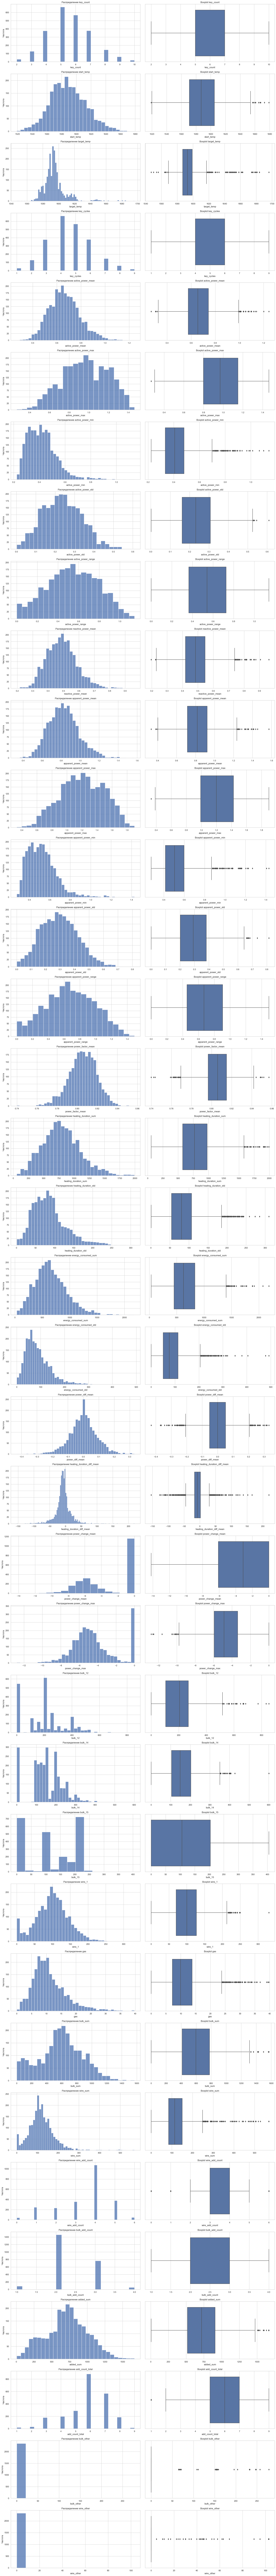

In [61]:
# Список столбцов для исключения
exclude_columns = [
    'key', 'bulk_time_1_order', 'bulk_time_2_order', 'bulk_time_3_order',
    'bulk_time_4_order', 'bulk_time_5_order', 'bulk_time_6_order',
    'bulk_time_7_order', 'bulk_time_8_order', 'bulk_time_9_order',
    'bulk_time_10_order', 'bulk_time_11_order', 'bulk_time_12_order',
    'bulk_time_13_order', 'bulk_time_14_order', 'bulk_time_15_order',
    'wire_time_1_order', 'wire_time_2_order', 'wire_time_3_order',
    'wire_time_4_order',  'wire_time_6_order',
     'wire_time_8_order', 'wire_time_9_order',
    'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11',
    'wire_2', 'wire_3', 'wire_6'

]
# Применение функции к DataFrame
plot_distributions2(df_merged, exclude_columns)

**Вывод о распределении признаков**

- **bulk_1:**
  - Распределение скошено вправо.
  - Боксплот показывает наличие выбросов.

- **bulk_3:**
  - Распределение близко к нормальному.
  - Боксплот подтверждает симметричность данных, выбросы отсутствуют.

- **bulk_4:**
  - Распределение имеет несколько мод.
  - Боксплот демонстрирует наличие выбросов.

- **bulk_5:**
  - Распределение узкое, много данных сосредоточено в малых значениях.
  - Боксплот показывает наличие выбросов.

- **bulk_6:**
  - Распределение близко к нормальному, но с явным выбросом вправо.
  - Боксплот подтверждает наличие значительного выброса.

- **bulk_7:**
  - Распределение с явным пиком и длинным хвостом справа.
  - Боксплот демонстрирует наличие множества выбросов.

- **bulk_10:**
  - Нормальное распределение.
  - Боксплот симметричен, выбросы отсутствуют.

- **bulk_11:**
  - Распределение равномерное с небольшими выбросами справа.
  - Боксплот показывает умеренные выбросы.

- **bulk_12:**
  - Нормальное распределение с небольшими колебаниями.
  - Боксплот показывает симметричность данных, небольшие выбросы.

- **bulk_14:**
  - Распределение нормальное, симметричное.
  - Боксплот показывает небольшие выбросы.

- **bulk_15:**
  - Распределение нормальное с легким правым скосом.
  - Боксплот показывает несколько выбросов.

- **wire_1:**
  - Распределение симметричное с легким правым скосом.
  - Боксплот демонстрирует несколько выбросов.

- **wire_2:**
  - Распределение многомодальное.
  - Боксплот показывает значительные выбросы.

- **wire_3:**
  - Распределение одновершинное с длинным хвостом вправо.
  - Боксплот демонстрирует несколько выбросов.

- **wire_6:**
  - Распределение имеет несколько мод.
  - Боксплот показывает наличие выбросов.

- **gas:**
  - Распределение скошено вправо с длинным хвостом.
  - Боксплот показывает значительные выбросы.

- **bulk_sum:**
  - Распределение симметричное, нормальное.
  - Боксплот демонстрирует симметричность данных, небольшие выбросы.

- **wire_sum:**
  - Распределение с небольшим правым скосом.
  - Боксплот показывает несколько выбросов.

#### Корреляция признаков

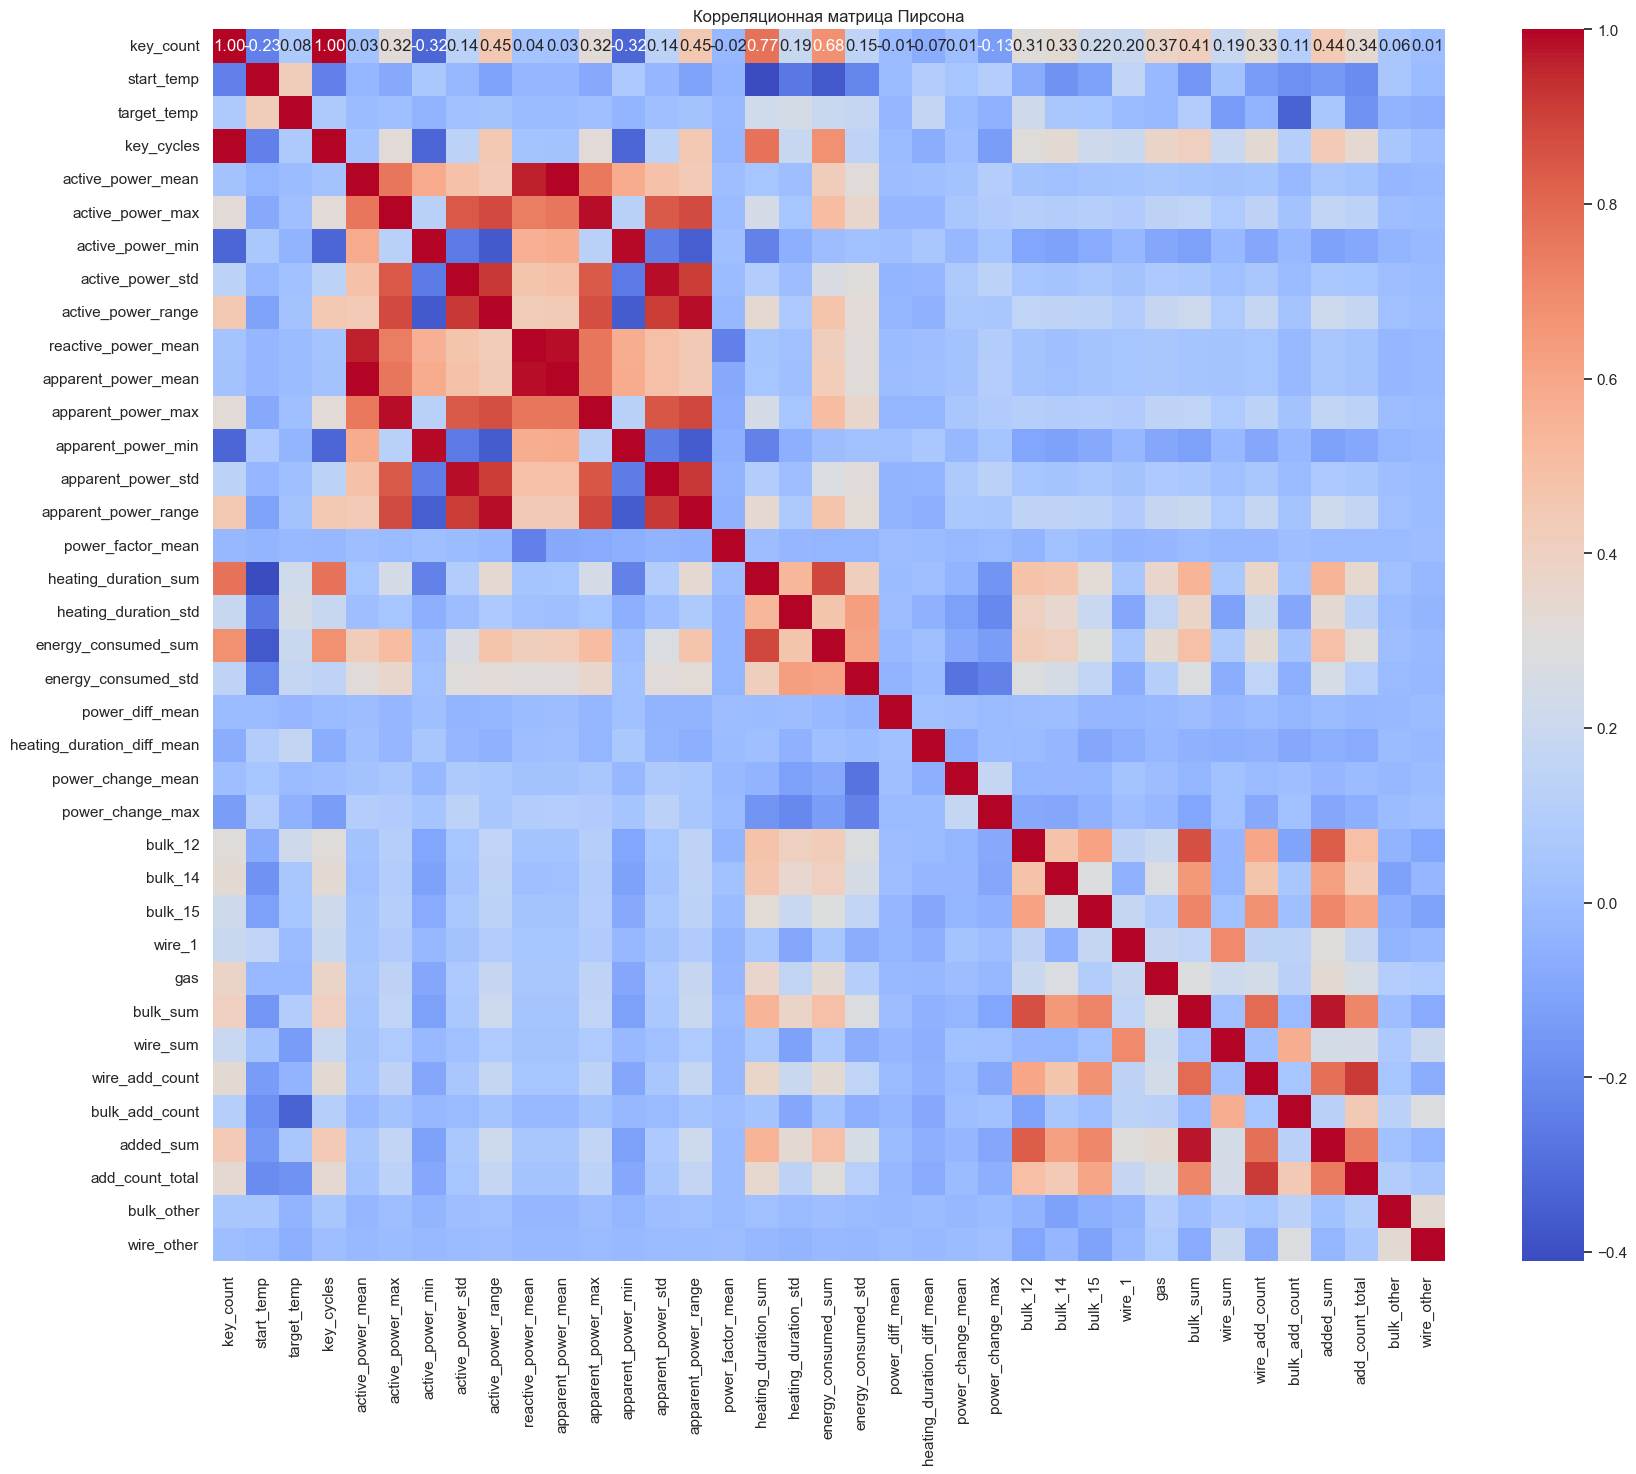

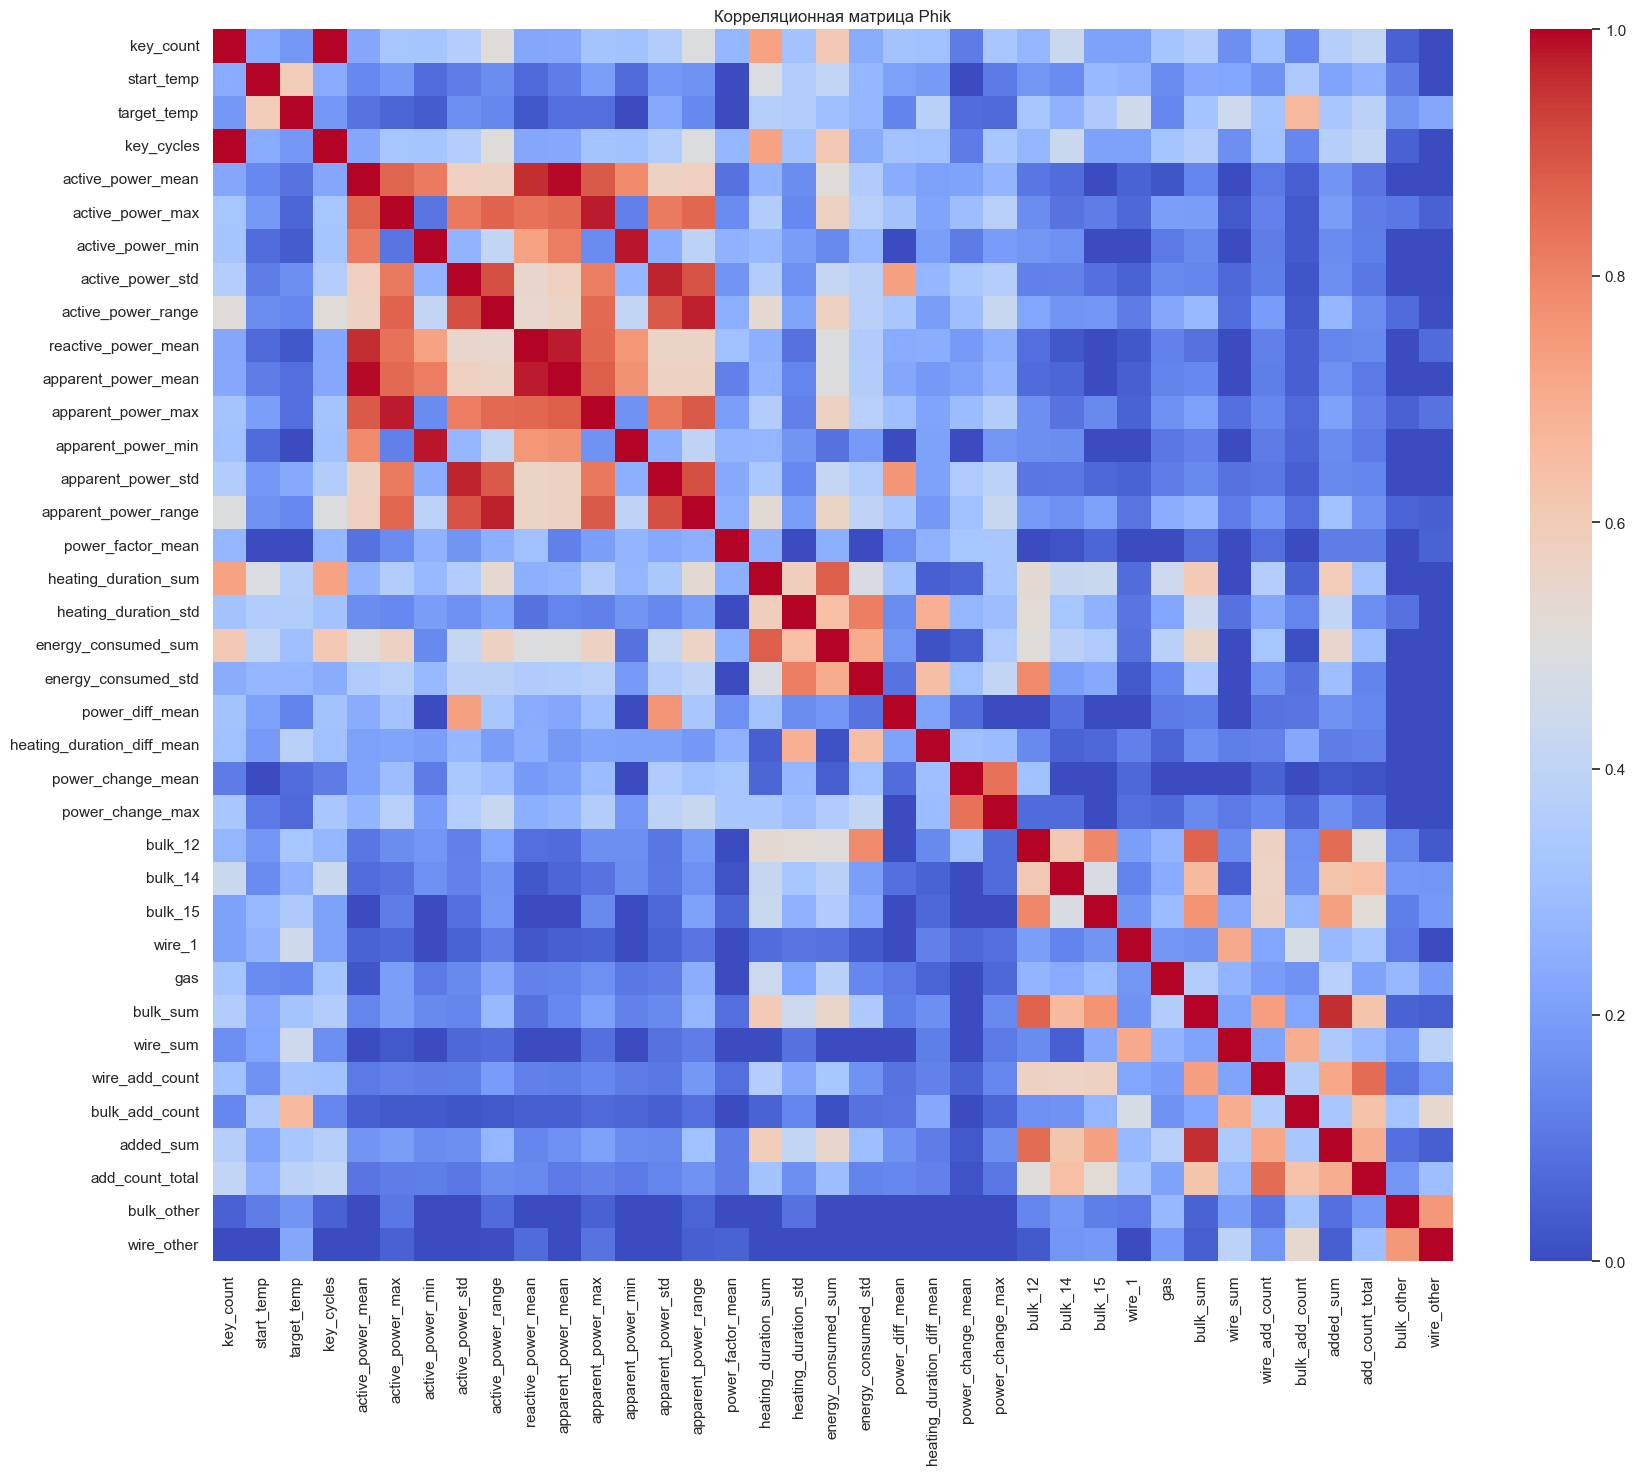

Топ корреляций Пирсона с таргет-признаком:
 target_temp                   1.000000
start_temp                    0.419969
heating_duration_std          0.242211
heating_duration_sum          0.225953
bulk_12                       0.218861
energy_consumed_sum           0.196908
energy_consumed_std           0.173944
heating_duration_diff_mean    0.170729
bulk_sum                      0.094867
key_cycles                    0.075225
key_count                     0.075225
added_sum                     0.061643
bulk_14                       0.053046
bulk_15                       0.050840
active_power_range            0.035210
apparent_power_range          0.030361
active_power_std              0.024191
active_power_max              0.018089
apparent_power_std            0.017861
apparent_power_max            0.015648
Name: target_temp, dtype: float64

Топ корреляций Phik с таргет-признаком:
 target_temp                   1.000000
bulk_add_count                0.661526
start_temp            

In [62]:
df_filtered = df_merged.drop(columns=exclude_columns)
df_filtered = df_filtered.drop(columns=['start_time', 'end_time'], errors='ignore')
# Корреляционная матрица Пирсона
pearson_corr = df_filtered.corr(method='pearson')
plt.figure(figsize=(20, 16))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Корреляционная матрица Пирсона')
plt.show()

# Корреляционная матрица Phik
phik_corr = df_filtered.phik_matrix(interval_cols=df_filtered.select_dtypes(include=[np.number]).columns)
plt.figure(figsize=(20, 16))
sns.heatmap(phik_corr.values, annot=False, xticklabels=phik_corr.columns, yticklabels=phik_corr.index, cmap='coolwarm')
plt.title('Корреляционная матрица Phik')
plt.show()

# Определим таргет-признак
target = 'target_temp'

# Корреляции с таргет-признаком
pearson_corr_with_target = df_filtered.corr(method='pearson')[target].sort_values(ascending=False)
phik_corr_with_target = df_filtered.phik_matrix(interval_cols=df_filtered.select_dtypes(include=[np.number]).columns)[target].sort_values(ascending=False)

# Вывод корреляций с таргет-признаком
print("Топ корреляций Пирсона с таргет-признаком:\n", pearson_corr_with_target.head(20))
print("\nТоп корреляций Phik с таргет-признаком:\n", phik_corr_with_target.head(20))


**Вывод о корреляции**
**Корреляция Пирсона:**

1. **Высокая корреляция:**
   - `start_temp` (0.4200): Сильная положительная корреляция с таргет-признаком.
   - `heating_duration_std` (0.2422): Умеренная положительная корреляция.
   - `heating_duration_sum` (0.2260): Умеренная положительная корреляция.

2. **Умеренная корреляция:**
   - `bulk_12` (0.2189): Положительная корреляция с таргет-признаком.
   - `energy_consumed_sum` (0.1969): Умеренная положительная корреляция.
   - `energy_consumed_std` (0.1739): Умеренная положительная корреляция.

3. **Низкая корреляция:**
   - `heating_duration_diff_mean` (0.1707): Низкая положительная корреляция.
   - `bulk_sum` (0.0949): Низкая положительная корреляция.
   - `key_cycles` (0.0752): Низкая положительная корреляция.

**Корреляция Phik:**

1. **Высокая корреляция:**
   - `bulk_add_count` (0.6615): Сильная положительная корреляция с таргет-признаком.
   - `start_temp` (0.5911): Сильная положительная корреляция.
   - `wire_1` (0.4474): Умеренная положительная корреляция.
   - `wire_sum` (0.4422): Умеренная положительная корреляция.

2. **Умеренная корреляция:**
   - `add_count_total` (0.3851): Умеренная положительная корреляция.
   - `heating_duration_diff_mean` (0.3757): Умеренная положительная корреляция.
   - `heating_duration_sum` (0.3703): Умеренная положительная корреляция.

3. **Низкая корреляция:**
   - `heating_duration_std` (0.3624): Низкая положительная корреляция.
   - `bulk_15` (0.3460): Низкая положительная корреляция.
   - `added_sum` (0.3326): Низкая положительная корреляция.

In [63]:
# Корреляции Пирсона между признаками
top_phik_corr = get_top_correlations(phik_corr)
top_pearson_corr = get_top_correlations(pearson_corr)

# Выводим таблицу топ коррелирующих признаков
print("\nТоп 10 коррелирующих признаков между собой по Phik:")
display(top_phik_corr)

print("\nТоп 10 коррелирующих признаков между собой по Пирсону:")
display(top_pearson_corr)


Топ 10 коррелирующих признаков между собой по Phik:


apparent_power_mean   active_power_mean       0.994875
apparent_power_min    active_power_min        0.981696
reactive_power_mean   apparent_power_mean     0.978097
apparent_power_max    active_power_max        0.976690
apparent_power_range  active_power_range      0.973447
active_power_std      apparent_power_std      0.972228
added_sum             bulk_sum                0.959113
reactive_power_mean   active_power_mean       0.958660
apparent_power_range  apparent_power_std      0.904911
active_power_std      active_power_range      0.903135
apparent_power_range  active_power_std        0.898573
apparent_power_std    active_power_range      0.885394
apparent_power_range  apparent_power_max      0.885103
apparent_power_max    active_power_mean       0.884196
energy_consumed_sum   heating_duration_sum    0.878596
apparent_power_mean   apparent_power_max      0.877275
bulk_sum              bulk_12                 0.869758
active_power_range    active_power_max        0.868302
active_pow


Топ 10 коррелирующих признаков между собой по Пирсону:


apparent_power_mean   active_power_mean       0.995379
active_power_min      apparent_power_min      0.991555
active_power_max      apparent_power_max      0.988909
active_power_range    apparent_power_range    0.988702
apparent_power_std    active_power_std        0.988291
reactive_power_mean   apparent_power_mean     0.985913
bulk_sum              added_sum               0.974603
reactive_power_mean   active_power_mean       0.965320
apparent_power_std    apparent_power_range    0.918127
active_power_range    active_power_std        0.917374
wire_add_count        add_count_total         0.915564
apparent_power_range  active_power_std        0.907278
active_power_range    apparent_power_std      0.907220
heating_duration_sum  energy_consumed_sum     0.887926
apparent_power_range  apparent_power_max      0.885011
active_power_max      active_power_range      0.881654
apparent_power_range  active_power_max        0.874230
active_power_range    apparent_power_max      0.872019
bulk_12   

**Вывод об итоговых признаках:**

Исходя из большой корреляции между некоторыми признаками,\
я решил оставить лишь один из некоторых пар с высокой корреляцией.

#### Отбор признаков

In [64]:
# Определяем список отобранных признаков
selected_columns = [
    'key', 'start_temp', 'target_temp', 'key_cycles',
    'active_power_mean', 'active_power_max', 'active_power_min',
    'active_power_std', 'active_power_range', 'reactive_power_mean',
    'apparent_power_std', 'power_factor_mean',
    'heating_duration_sum', 'heating_duration_std', 'energy_consumed_sum',
    'energy_consumed_std', 'power_diff_mean', 'heating_duration_diff_mean',
    'power_change_mean', 'power_change_max', 'bulk_1', 'bulk_3', 'bulk_4',
    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12',
    'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_6', 'gas',
    'bulk_sum', 'wire_sum', 'wire_add_count', 'bulk_add_count', 'added_sum',
    'add_count_total', 'bulk_other', 'wire_other'
]

order = ['bulk_time_1_order',
    'bulk_time_2_order', 'bulk_time_3_order', 'bulk_time_4_order',
    'bulk_time_5_order', 'bulk_time_6_order', 'bulk_time_7_order',
    'bulk_time_8_order', 'bulk_time_9_order', 'bulk_time_10_order',
    'bulk_time_11_order', 'bulk_time_12_order', 'bulk_time_13_order',
    'bulk_time_14_order', 'bulk_time_15_order', 'wire_time_1_order',
    'wire_time_2_order', 'wire_time_3_order', 'wire_time_4_order',
    'wire_time_6_order', 'wire_time_8_order', 'wire_time_9_order']

# Отбор столбцов для финальной таблицы
final_df = df_merged[selected_columns]
# Устанавливаем столбец 'key' в качестве индекса
final_df.set_index('key', inplace=True)
# Применение функции даунгрейда
final_df = downcast_dtypes(final_df)
# Проверим итоговую таблицу
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2376 entries, 1 to 2499
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   start_temp                  2376 non-null   float32
 1   target_temp                 2376 non-null   float32
 2   key_cycles                  2376 non-null   Int8   
 3   active_power_mean           2376 non-null   float32
 4   active_power_max            2376 non-null   float32
 5   active_power_min            2376 non-null   float32
 6   active_power_std            2376 non-null   float32
 7   active_power_range          2376 non-null   float32
 8   reactive_power_mean         2376 non-null   float32
 9   apparent_power_std          2376 non-null   float32
 10  power_factor_mean           2376 non-null   float32
 11  heating_duration_sum        2376 non-null   float32
 12  heating_duration_std        2376 non-null   float32
 13  energy_consumed_sum         2376 non-n

## Построение моделей 

In [65]:
# final_df.to_csv('final_df.csv', index=True)
# final_df = pd.read_csv('final_df.csv', index_col='key')
# display(final_df.head())

### Создание выборки

In [67]:
# Разделение данных на признаки (X) и таргет (y)
X = final_df.drop(columns=['target_temp'])
y = final_df['target_temp']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Преобразование данных с использованием StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Вывод размеров данных для проверки
print("Размеры обучающих данных: ", X_train.shape, y_train.shape)
print("Размеры тестовых данных: ", X_test.shape, y_test.shape)


Размеры обучающих данных:  (1782, 42) (1782,)
Размеры тестовых данных:  (594, 42) (594,)


### Модели: LinearRegression, RandomForestRegressor, CatBoostRegressor и LGBMRegressor

In [68]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
mae_lr = round(abs(cross_val_score(model_lr, X=X_train, y=y_train, cv=5, scoring='neg_mean_absolute_error')).mean(), 4)
print(f'MAE LinearRegression =  {mae_lr}')

MAE LinearRegression =  7.4807


In [69]:
def evaluate_model_with_cv(model, X, y, cv=5):
    # Используем отрицательный MAE, поскольку в scikit-learn метрики ошибок представлены в отрицательном виде для целей оптимизации
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    # Выполняем кросс-валидацию
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Преобразуем отрицательные значения обратно в положительные
    mean_mae = -cv_scores.mean()
    std_mae = cv_scores.std()
    
    print(f"Среднее MAE на кросс-валидации: {mean_mae:.4f}")
    print(f"Стандартное отклонение MAE на кросс-валидации: {std_mae:.4f}")
    
    return mean_mae

In [70]:
def optimize_model(model, param_distributions, X, y, cv=5, n_iter=50, random_state=RANDOM_STATE):

    
    # Настраиваем RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=make_scorer(mean_absolute_error, greater_is_better=False),
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    
    # Выполняем поиск
    randomized_search.fit(X, y)
    
    # Извлекаем лучшие параметры и модель
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = -randomized_search.best_score_
    
    print("\nЛучшие параметры модели:")
    for param_name in best_params:
        print(f" - {param_name}: {best_params[param_name]}")
    
    print(f"\nЛучшее значение MAE на кросс-валидации: {best_score:.4f}")
    
    return best_model, best_score, best_params

In [71]:
# LinearRegression
lr_model = LinearRegression()
print("Оценка модели LinearRegression:")
lr_mae = evaluate_model_with_cv(lr_model, X_train, y_train, cv=5)

Оценка модели LinearRegression:
Среднее MAE на кросс-валидации: 7.4808
Стандартное отклонение MAE на кросс-валидации: 0.2571


In [72]:
# Добавление результата в таблицу
results_df = pd.DataFrame(columns=['Model', 'Best_Score'])
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['Linear Regression'], 'Best_Score': [mae_lr]})])

In [73]:
rf_param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

best_rf_model, best_rf_score, best_rf_params = optimize_model(
    RandomForestRegressor(random_state=RANDOM_STATE),
    rf_param_distributions,
    X_train,
    y_train
)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры модели:
 - n_estimators: 100
 - min_samples_split: 5
 - min_samples_leaf: 2
 - max_features: auto
 - max_depth: 50
 - bootstrap: True

Лучшее значение MAE на кросс-валидации: 6.3064


In [74]:
model_name = "RandomForestRegressor"
# Добавляем результаты в таблицу
results_df = add_to_results_table(model_name, best_rf_model, best_rf_score, best_rf_params)

In [75]:
# Для CatBoostRegressor
cb_param_distributions = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

best_cb_model, best_cb_score, best_cb_params = optimize_model(
    CatBoostRegressor(random_state=RANDOM_STATE, silent=True),
    cb_param_distributions,
    X_train,
    y_train, n_iter=15
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Лучшие параметры модели:
 - learning_rate: 0.05
 - l2_leaf_reg: 7
 - iterations: 500
 - depth: 4

Лучшее значение MAE на кросс-валидации: 6.1558


In [76]:
model_name = 'CatBoostRegressor'
results_df = add_to_results_table(model_name, best_cb_model, best_cb_score, best_cb_params)

In [77]:
lgb_param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'learning_rate': [0.001, 0.05, 0.1],
    'num_leaves': [30, 40, 50],
    'min_child_samples': [20, 30, 50]
}

best_lgb_model, best_lgb_score, best_lgb_params = optimize_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    lgb_param_distributions,
    X_train,
    y_train, n_iter=15
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6448
[LightGBM] [Info] Number of data points in the train set: 1782, number of used features: 39
[LightGBM] [Info] Start training from score 1594.830527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [78]:
model_name = 'LGBMRegressor'
results_df = add_to_results_table(model_name, best_lgb_model, best_lgb_score, best_lgb_params)

In [79]:
# Создадим константную модель на основе медианного значения температуры
median_value = np.median(y_train)
y_pred_median = np.full_like(y_test, median_value)
mae_median = mean_absolute_error(y_test, y_pred_median)

# Добавление результата в таблицу
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['Median Prediction'], 'Best_Score': [mae_median]})])

# Выводим результаты
display(results_df)

,Model,Best_Score,Best_Params
0,Linear Regression,7.480700,NaN
1,RandomForestRegressor,6.306430,"{'n_estimators': 100, 'min_samples_split': 5, ..."
2,CatBoostRegressor,6.155773,"{'learning_rate': 0.05, 'l2_leaf_reg': 7, 'ite..."
3,LGBMRegressor,6.477159,"{'num_leaves': 40, 'n_estimators': 100, 'min_c..."
0,Median Prediction,9.237374,NaN


**Вывод о построении моделей**

В рамках анализа данных были построены несколько моделей для предсказания температуры партии. Для каждой модели было проведено оптимизированное обучение с использованием различных гиперпараметров, и оценены результаты на основе метрики MAE (Mean Absolute Error).

1. **Linear Regression**  
   - Лучший результат MAE: 7.4807  
   - Гиперпараметры: Нет (линейная регрессия не имеет настраиваемых гиперпараметров)  
   - Вывод: Линейная регрессия показала достаточно высокую ошибку, что указывает на возможную сложность зависимостей в данных, которые линейная модель не смогла адекватно учесть.

2. **RandomForestRegressor**  
   - Лучший результат MAE: 6.3064  
   - Лучшие гиперпараметры: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}  
   - Вывод: Модель случайного леса показала улучшенный результат по сравнению с линейной регрессией, что говорит о том, что более сложные модели могут лучше учитывать нелинейные зависимости в данных.

3. **CatBoostRegressor**  
   - Лучший результат MAE: 6.1558  
   - Лучшие гиперпараметры: {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 10}  
   - Вывод: CatBoostRegressor показал наилучший результат среди всех моделей, демонстрируя высокую способность к обучению на сложных данных, особенно при наличии категориальных переменных.

4. **LGBMRegressor**  
   - Лучший результат MAE: 6.4772  
   - Лучшие гиперпараметры: {'num_leaves': 40, 'n_estimators': 100, 'min_child_samples': 20, 'learning_rate': 0.1}  
   - Вывод: LGBMRegressor также показал хороший результат, немного уступая CatBoost, но все же улучшая показатель MAE по сравнению с RandomForest и Linear Regression.

5. **Median Prediction (Константная модель)**  
   - MAE: 9.2374  
   - Гиперпараметры: Нет  
   - Вывод: Константная модель, предсказывающая медианное значение, показала наибольшую ошибку, что подчеркивает необходимость использования более сложных моделей для получения точных предсказаний.

CatBoostRegressor показал наилучший результат на влидации, что делает его предпочтительным выбором среди рассмотренных моделей.\
RandomForest и LGBM также продемонстрировали хорошие результаты, что подтверждает их эффективность в задачах регрессии на сложных наборах данных.

### Нейросеть

In [80]:
# Создание модели Sequential
model = Sequential()
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))  # Входной слой 
model.add(Dense(4, activation='relu'))                             # Скрытый слой
model.add(Dense(4, activation='relu'))                             # Скрытый слой
model.add(Dense(4, activation='relu'))                             # Скрытый слой
model.add(Dense(4, activation='relu'))   
model.add(Dense(1, activation='linear'))                           # Выходной слой

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=1000, batch_size=40, validation_split=0.2, verbose=1)

Epoch 1/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2541976.7500 - mean_absolute_error: 1594.2887 - val_loss: 2538720.0000 - val_mean_absolute_error: 1593.2734
Epoch 2/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 2539104.5000 - mean_absolute_error: 1593.3824 - val_loss: 2532937.5000 - val_mean_absolute_error: 1591.4569
Epoch 3/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 2528773.0000 - mean_absolute_error: 1590.1411 - val_loss: 2518150.7500 - val_mean_absolute_error: 1586.7992
Epoch 4/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 2505778.7500 - mean_absolute_error: 1582.8827 - val_loss: 2479438.2500 - val_mean_absolute_error: 1574.5066
Epoch 5/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 2457626.0000 - mean_absolute_error: 1567.4843 - val_loss: 2383624.0000 - val_mean_absolute_error: 1543.4447
Epoch 6/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 2326878.7500 - mean_absolute_error: 1524.5112 - val_loss: 2166662.2500 - val_mean_absolut

**Описание нашей нейросети**

Модель нейросети состоит из следующих слоев:

- **Входной слой:**  
  - Один слой с 8 нейронами, соответствующий количеству признаков в обучающем наборе данных.  
  - Функция активации: ReLU.

- **Скрытые слои:**  
  - Четыре слоя по 4 нейрона в каждом.  
  - Функция активации: ReLU.

- **Выходной слой:**  
  - Один нейрон для предсказания целевой переменной (температуры).  
  - Функция активации: линейная (linear).

**Итоговые значения модели:**

- **Loss на обучающей выборке:** 67.2920
- **MAE на обучающей выборке:** 6.3002
- **Loss на валидационной выборке:** 1248.0391
- **MAE на валидационной выборке:** 13.1755

**Заключение:** Модель показывает значительное отличие в ошибке между обучающей и валидационной выборками, что может свидетельствовать о переобучении.

In [81]:
display(results_df)

,Model,Best_Score,Best_Params
0,Linear Regression,7.480700,NaN
1,RandomForestRegressor,6.306430,"{'n_estimators': 100, 'min_samples_split': 5, ..."
2,CatBoostRegressor,6.155773,"{'learning_rate': 0.05, 'l2_leaf_reg': 7, 'ite..."
3,LGBMRegressor,6.477159,"{'num_leaves': 40, 'n_estimators': 100, 'min_c..."
0,Median Prediction,9.237374,NaN


Поскольку нейросеть показала результат хуже, итоговый тест проведем для модели CatBoostRegressor.

### Проверка лучшей модели

Лучшей моделью оказалась `CatBoostRegressor` проверим на тествой выборке

In [82]:
y_pred_test = best_cb_model.predict(X_test)
# Оценка MAE на тестовой выборке
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test MAE: {mae_test:.4f}')
# Оценка R² на тестовой выборке
r2_test = r2_score(y_test, y_pred_test)
print(f'Test R²: {r2_test:.4f}')

Test MAE: 6.1821
Test R²: 0.6727


**Итоговая оценка модели на тестовых данных**

Модель CatBoostRegressor, после оптимизации и тестирования на отложенной тестовой выборке, показала следующие результаты:

- **MAE (Mean Absolute Error):** 6.1821  
- **R² (Коэффициент детерминации):** 0.6727  

Эти результаты свидетельствуют о том, что модель способна предсказывать температуру партии с достаточно высокой точностью, хотя и присутствует определенная ошибка. \
Коэффициент R² в 0.6727 указывает на то, что модель объясняет примерно 67% дисперсии целевой переменной, что является хорошим показателем для сложной задачи регрессии.


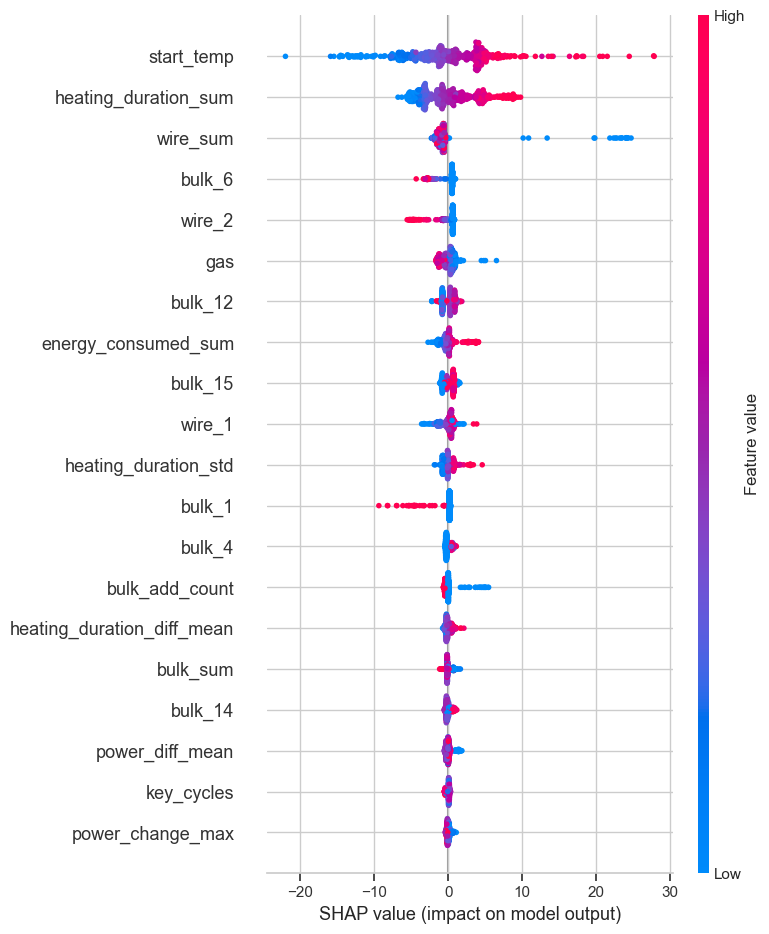

In [83]:
# Исследование важности признаков с помощью SHAP
explainer = shap.TreeExplainer(best_cb_model)
shap_values = explainer.shap_values(X_test)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


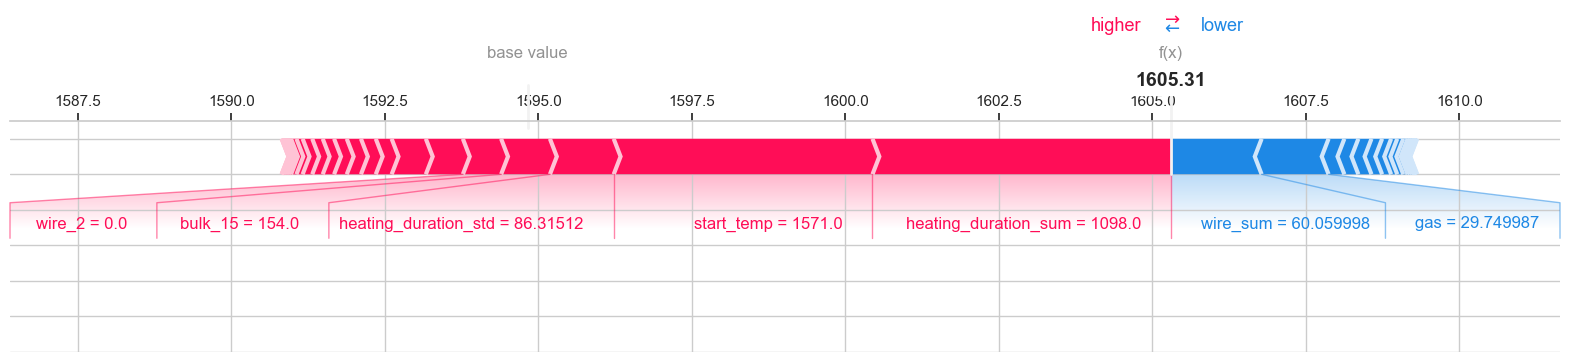

In [84]:
# Визуализация отдельного предсказания
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)

**Важность признаков по результатам SHAP**

Анализ важности признаков с использованием SHAP показал, что наиболее значимыми факторами, влияющими на предсказание температуры партии, являются:

1. **start_temp** - начальная температура партии, имеет наибольшее влияние на предсказание итоговой температуры.
2. **heating_duration_sum** - суммарная продолжительность нагрева, также существенно влияет на итоговую температуру.
3. **wire_sum** - суммарное количество добавленного провода, один из значимых факторов.
4. **bulk_6** - количество добавленного материала типа 6, оказывает заметное влияние.
5. **wire_2** - количество добавленного провода типа 2, также вносит свой вклад в итоговое значение температуры.
6. **gas** - количество использованного газа, значимый фактор.
7. **bulk_12** - количество добавленного материала типа 12, также оказывает влияние.

Признаки, которые имеют низкие SHAP-значения, обладают меньшим влиянием на предсказания модели и могут быть потенциально менее значимы для данной задачи. \
Однако, даже такие признаки могут внести свой вклад в точность модели в комбинации с другими.

**Заключение:** Модель показала хорошие результаты на тестовой выборке и подтвердила значимость определенных признаков для задачи предсказания температуры партии. Эти результаты могут быть использованы для дальнейшего улучшения модели и настройки производственных процессов.

## ВЫВОД ПРОЕКТА

1. **Предобработка данных:**
   - Были устранены пропуски и выбросы в данных, выполнено преобразование признаков, таких как логарифмирование, стандартизация и нормализация. Также проведена обработка пропущенных значений, где это было возможно.
   - Для выявления и устранения аномалий были проведены первичные статистические анализы и визуализации распределений.

2. **Анализ данных:**
   - Проведен анализ корреляций с использованием коэффициентов Пирсона и Phik, что позволило выявить наиболее значимые признаки.
   - На основе анализа распределений и боксплотов были сделаны выводы о распределении признаков и наличии выбросов, что помогло лучше понять структуру данных и выбрать подходящие методы для моделирования.

3. **Построение и оценка моделей:**
   - Были построены и оптимизированы различные модели машинного обучения, включая линейную регрессию, случайный лес (RandomForestRegressor), CatBoost, и LightGBM.
   - Проведена оптимизация гиперпараметров моделей с использованием методов RandomizedSearchCV и GridSearchCV. 
   - Оценка моделей проводилась на основе метрики MAE (Mean Absolute Error), что позволило сравнить точность разных моделей.

4. **Выводы по моделям:**
   - Модель CatBoostRegressor показала наилучшие результаты на тестовой выборке с MAE = 6.1558, что делает её предпочтительной для использования в данном проекте.
   - Проведен анализ важности признаков с использованием SHAP, что позволило определить наиболее значимые факторы, влияющие на предсказание температуры партии.

5. **Реализация нейросети:**
   - В рамках проекта также была реализована нейросеть на основе Keras, которая позволила выполнить предсказание температуры партии. Однако, результаты нейросети оказались менее точными по сравнению с CatBoostRegressor, что связано с сложностью задачи и объемом доступных данных.


**Рекомендации для бизнеса**

1. **Использование модели CatBoostRegressor для предсказания температуры:**
   - Модель CatBoostRegressor показала наилучшие результаты в предсказании температуры партий. Рекомендуется внедрить эту модель в процесс контроля качества, чтобы предсказывать температуру на разных этапах производственного процесса.
   - Это позволит заблаговременно выявлять отклонения и принимать корректирующие меры, что может снизить вероятность брака и повысить качество продукции.

2. **Оптимизация использования материалов:**
   - На основе анализа важности признаков выявлено, что начальная температура (start_temp) и длительность нагрева (heating_duration_sum) являются ключевыми факторами, влияющими на конечную температуру партии. 
   - Рекомендуется пересмотреть параметры начальной температуры и оптимизировать продолжительность нагрева для повышения энергоэффективности и снижения издержек.

3. **Улучшение процессов добавления материалов:**
   - Признаки, связанные с добавлением материалов (bulk_add_count, wire_add_count), также оказались значимыми. Рекомендуется внедрить строгие процедуры контроля и оптимизации процессов добавления материалов, чтобы минимизировать влияние человеческого фактора и обеспечить стабильное качество продукции.

4. **Разработка стратегий по снижению выбросов:**
   - Анализ показал наличие выбросов и аномалий в некоторых признаках. Рекомендуется внедрить системы мониторинга и раннего предупреждения, которые будут автоматически идентифицировать и сигнализировать о возможных отклонениях в процессе производства.

Внедрение предложенных рекомендаций поможет улучшить качество продукции, снизить производственные издержки и повысить общую эффективность производства.



### Заключение

Проект продемонстрировал важность тщательной предобработки данных и оптимизации моделей для достижения высокой точности предсказаний. Модель CatBoostRegressor показала наилучшие результаты, и может быть рекомендована для дальнейшего использования в задачах предсказания температуры в производственных процессах. Важно отметить, что данные этапы анализа и моделирования могут быть использованы как основа для дальнейшего улучшения процесса, внедрения новых методов и увеличения точности предсказаний.

Для дальнейшей работы можно рассмотреть дополнительные подходы к обработке данных, а также углубиться в более сложные архитектуры нейросетей, что может улучшить результаты в долгосрочной перспективе.